In [1]:
from neural_priors.utils.data import get_all_behavioral_data #Subject, get_all_subject_ids, get_all_behavioral_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
from scipy import stats, odr, optimize

In [2]:
plt.rcParams['legend.frameon'] = False
np.set_printoptions(linewidth=140)
pd.set_option('display.width', 170) # 80
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 70)

In [3]:
import apc_utils as apc

In [4]:
CONDITIONS = ['narrow', 'wide']
COLORS_COND = {'narrow':'C0', 'wide':'C1'}

In [5]:
bids_folder = '../../ds-neuralpriors'

In [6]:
beh = get_all_behavioral_data(bids_folder=bids_folder) #, subjects=[f'{i}'.rjust(2,'0') for i in range(1,23)])
#beh = beh.droplevel(['session', 'run', 'trial_nr'])

In [7]:
beh

onset  phase  response  nr_frames     n  jitter  start_marker_position  response_time   onset_abs  duration   range  error  \
subject session run trial_nr                                                                                                                                    
01      1       1   1          68.826307      5       NaN       30.0  11.0     6.0                   24.0            NaN   76.378611  0.500457  narrow    NaN   
                    2          76.016292      5      19.0       31.0  23.0     4.0                   14.0       1.317963   83.568595  0.517188  narrow   -4.0   
                    3          87.026471      5      25.0       30.0  23.0     6.0                   11.0       0.834244   94.578775  0.500469  narrow    2.0   
                    4          97.085656      5      24.0       30.0  22.0     5.0                   22.0       1.701381  104.637959  0.500559  narrow    2.0   
                    5         106.744768      5      17.0       31.0  21.0     5.0                   22.0       2.018881  114.297072  0.517009  narrow   -4.0   
...                                  ...    ...       ...        ...   ...     ...                    ...            ...         ...       ...     ...    ...   
27      2       8   26        280.689830      5      22.0       30.0  20.0     6.0                   23.0       1.384728  284.091391  0.500461  narrow    2.0   
                    27        290.448877      5      23.0       31.0  24.0     4.0                   22.0       1.951233  293.850438  0.517034  narrow   -1.0   
                    28        301.041931      5      23.0       30.0  21.0     6.0                   12.0       1.051049  304.443492  0.500531  narrow    2.0   
                    29        308.999370      5      14.0       30.0  10.0     4.0                   22.0       1.635088  312.400931  0.500508  narrow    4.0   
                    30        318.875303      5      21.0       30.0  18.0     5.0                   11.0       0.500447  322.276864  0.500352  narrow    3.0   

                              abs_error  squared_error  
subject session run trial_nr                            
01      1       1   1               NaN            NaN  
                    2               4.0           16.0  
                    3               2.0            4.0  
                    4               2.0            4.0  
                    5               4.0           16.0  
...                                 ...            ...  
27      2       8   26              2.0            4.0  
                    27              1.0            1.0  
                    28              2.0            4.0  
                    29              4.0           16.0  
                    30              3.0            9.0  

[12000 rows x 14 columns]

## Bin edges

In [8]:
BINS_EDGES = {'narrow':{}, 'wide':{}}
BINS_EDGES['narrow']['A'] = np.arange(10,27,1)-.5
BINS_EDGES['wide']['A']   = np.arange(10,42,1)-.5
#
BINS_EDGES['narrow'][2] = np.array([9.5, 17.5, 25.5])
BINS_EDGES['narrow'][3] = np.array([9.5, 14.5, 20.5, 25.5])
BINS_EDGES['narrow'][4] = np.array([9.5, 13.5, 17.5, 21.5, 25.5])
BINS_EDGES['narrow'][5] = np.array([9.5, 12.5, 15.5, 19.5, 22.5, 25.5])
BINS_EDGES['narrow'][6] = np.array([9.5, 11.5, 14.5, 17.5, 20.5, 23.5, 25.5])
BINS_EDGES['narrow'][7] = np.array([9.5, 11.5, 13.5, 16.5, 18.5, 21.5, 23.5, 25.5])
#
BINS_EDGES['wide'][2] = np.array([9.5, 24.5, 40.5])
BINS_EDGES['wide'][3] = np.array([9.5, 19.5, 30.5, 40.5])
BINS_EDGES['wide'][4] = np.array([9.5, 16.5, 24.5, 32.5, 40.5])
BINS_EDGES['wide'][5] = np.array([9.5, 15.5, 21.5, 28.5, 34.5, 40.5])
BINS_EDGES['wide'][6] = np.array([9.5, 14.5, 19.5, 24.5, 30.5, 35.5, 40.5])
BINS_EDGES['wide'][7] = np.array([9.5, 13.5, 17.5, 22.5, 27.5, 32.5, 36.5, 40.5])

In [9]:
def count_nb_int(bins_edges):
    counts = []
    for i in range(len(bins_edges)-1):
        a = int( np.ceil( bins_edges[i] ) )
        b = bins_edges[i+1]
        if b == np.floor(b):
            if i+1 < len(bins_edges)-1: # not the last
                b = int(np.floor(b)-1)
            else:
                b = int(b)
        else:
            b = int(np.floor(b))
        counts.append( b-a+1 )
    return counts

In [10]:
for rg in ['narrow', 'wide']:
    print(rg)
    for k,v in BINS_EDGES[rg].items():
        print(k, count_nb_int(v), sum(count_nb_int(v)) )

narrow
A [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 16
2 [8, 8] 16
3 [5, 6, 5] 16
4 [4, 4, 4, 4] 16
5 [3, 3, 4, 3, 3] 16
6 [2, 3, 3, 3, 3, 2] 16
7 [2, 2, 3, 2, 3, 2, 2] 16
wide
A [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 31
2 [15, 16] 31
3 [10, 11, 10] 31
4 [7, 8, 8, 8] 31
5 [6, 6, 7, 6, 6] 31
6 [5, 5, 5, 6, 5, 5] 31
7 [4, 4, 5, 5, 5, 4, 4] 31


## Compute summary statistics 

In [104]:
def estimate_mean_responses_empirical(data):
    xs = np.arange( data.n.min(), data.n.max()+1 )
    return {x:data.response[data.n==x].mean() for x in xs}
#
def estimate_mean_responses_ols(data, return_pars=False):
    A = np.vstack([data.n, np.ones(len(data.n))]).T
    m, c = np.linalg.lstsq(A, data.response, rcond=None)[0]
    xs = np.arange( data.n.min(), data.n.max()+1 )
    r = { x : m*x + c for x in xs}
    if return_pars:
        return r, (m, c)
    return r
#
def estimate_mean_responses_gaussian_kernel(data, conv_w, xs=None):
    if xs is None:
        xs = np.arange(int(data.n.min()), int(data.n.max())+1)
    return dict( zip( *apc.smooth_ys(conv_w, data.n, data.response, xs) ) )

In [105]:
subject_ids = beh.index.get_level_values('subject').unique()

In [125]:
nbSubjs = len(subject_ids)
binSizes = ['A', 7]
binNs   = {cond:{k:[] for k in binSizes} for cond in CONDITIONS} # binNs['narrow'][7] = array of shape (nb subjects, 7)
binAvgs = {cond:{k:[] for k in binSizes} for cond in CONDITIONS}
binAvgs_sem = {cond:{k:[] for k in binSizes} for cond in CONDITIONS}
binStds = {cond:{k:[] for k in binSizes} for cond in CONDITIONS}
binStds_sesd = {cond:{k:[] for k in binSizes} for cond in CONDITIONS}
binSqrtMses = {cond:{k:[] for k in binSizes} for cond in CONDITIONS}
binSqrtMses_se = {cond:{k:[] for k in binSizes} for cond in CONDITIONS}
for ii,sid in enumerate( subject_ids ):
    sdat = beh.loc[sid] #dfAn.xs(str(sid).rjust(2, '0'), 0, 'subject')
    for cond in CONDITIONS:
        datC = sdat[sdat.range==cond]
        datC = datC[~pd.isna(datC.response)]
        #mresps = estimate_mean_responses_empirical(datC)
        #ax.plot(*list(zip(*mresps.items())), c=COLORS_COND[cond], marker='.', ms=5, mec='none', alpha=.4, lw=1)
        mresps = estimate_mean_responses_gaussian_kernel(datC, conv_w={'narrow':.5, 'wide':1}[cond]*2)
        #ax.plot(*list(zip(*mresps.items())), c=COLORS_COND[cond], ls='-', )
        datC['excursion'] = datC.apply(axis=1, func=lambda row: row.response - mresps[row.n])
        for k in binSizes:
            bins_edges = BINS_EDGES[cond][k]
            binned_data = apc.split_in_bins(datC, bin_edges=bins_edges, xs='n')
            avgz = [b.response.mean() for b in binned_data]
            avgz_sem = [ stats.sem(b.response) for b in binned_data]
            stdz = [b.excursion.std() if len(b.excursion)>1 else np.nan for b in binned_data]
            stdz_sesd = [apc.sesd( b.excursion ) if len(b.excursion)>1 else np.nan for b in binned_data]
            ns = np.array([b.n.mean() for b in binned_data])
            sqrt_msez = [ np.sqrt( (b.error**2).mean() ) for b in binned_data ]
            sqrt_msez_se = [ apc.sesd( b.error ) for b in binned_data ] ### Correct???
            binStds[cond][k].append(stdz)
            binAvgs[cond][k].append(avgz)
            binNs[cond][k].append(ns)
            binAvgs_sem[cond][k].append(avgz_sem)
            binStds_sesd[cond][k].append(stdz_sesd)
            binSqrtMses[cond][k].append(sqrt_msez)
            binSqrtMses_se[cond][k].append(sqrt_msez_se) 
for cond in CONDITIONS:
    for k in binSizes:
        binNs[cond][k] = np.array(binNs[cond][k])
        binAvgs[cond][k] = np.array(binAvgs[cond][k])
        binStds[cond][k] = np.array(binStds[cond][k])
        binAvgs_sem[cond][k] = np.array(binAvgs_sem[cond][k])
        binStds_sesd[cond][k] = np.array(binStds_sesd[cond][k])
        binSqrtMses[cond][k] = np.array(binSqrtMses[cond][k])
        binSqrtMses_se[cond][k] = np.array(binSqrtMses_se[cond][k])

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Estimate vs Number

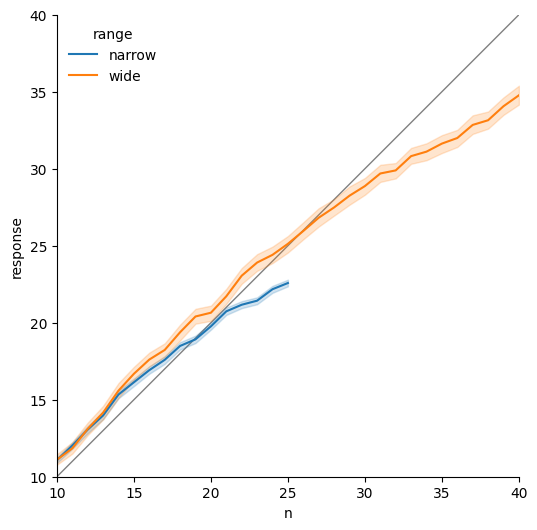

In [12]:
plt.figure(figsize=(6,6))
ax = sns.lineplot(x='n', y='response', data=beh, hue='range',)
ax.set_aspect(1)
apc.removeAxSpines(ax)
ax.axline((10,10), slope=1, c='grey', ls='-', lw=1, zorder=-1000)
for rg in ['narrow', 'wide']:
    dfrg = beh[beh.range==rg]
    #mresps = estimate_mean_responses_ols(dfrg[~pd.isna(dfrg.response)])
    #ax.plot(*list(zip(*mresps.items())), c=COLORS_COND[rg], ls='--', lw=1)
    #mresps = estimate_mean_responses_gaussian_kernel(dfrg, conv_w=1)
    #ax.plot(*list(zip(*mresps.items())), c=COLORS_COND[rg], ls=':', lw=1)
ax.set_xlim(10,40); ax.set_ylim(10,40);

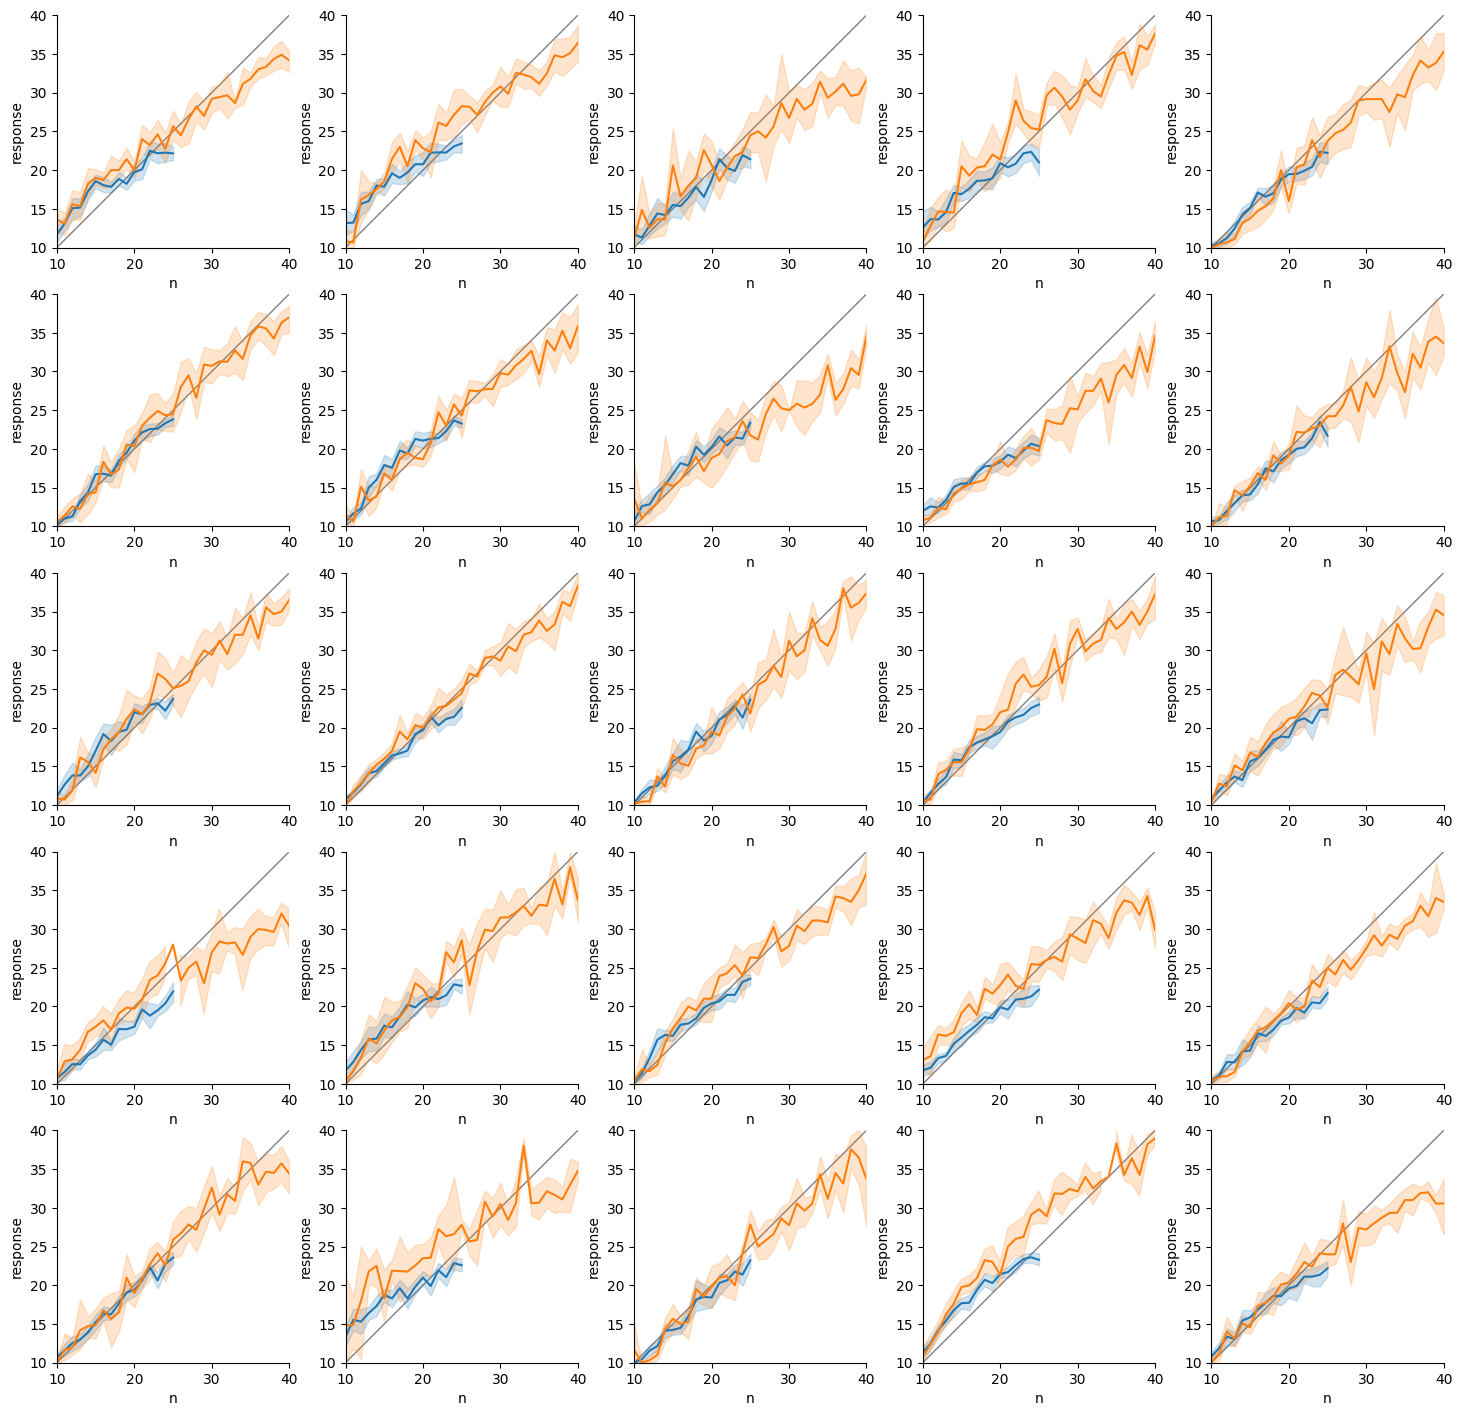

In [14]:
nbSubjs = len(subject_ids)
ncols = 5; nrows = int(np.ceil(nbSubjs/ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18,3.5*np.ceil(nbSubjs/ncols)) )
all_axs = axs.flatten()
for ii,sid in enumerate( subject_ids ):
    ax = all_axs[ii]
    ax.set_aspect(1)
    sdat = beh.loc[sid] #.xs(str(sid).rjust(2, '0'), 0, 'subject')
    for cond in CONDITIONS:
        datC = sdat[sdat.range==cond]
        sns.lineplot(data=datC, x='n', y='response', ax=ax)
    apc.removeAxSpines(ax)
    ax.axline((10,10), slope=1, c='grey', ls='-', lw=1, zorder=-1000)
    ax.set_xlim(10,40); ax.set_ylim(10,40);
ii += 1
while ii < len(all_axs):
    all_axs[ii].axis('off')
    ii+=1

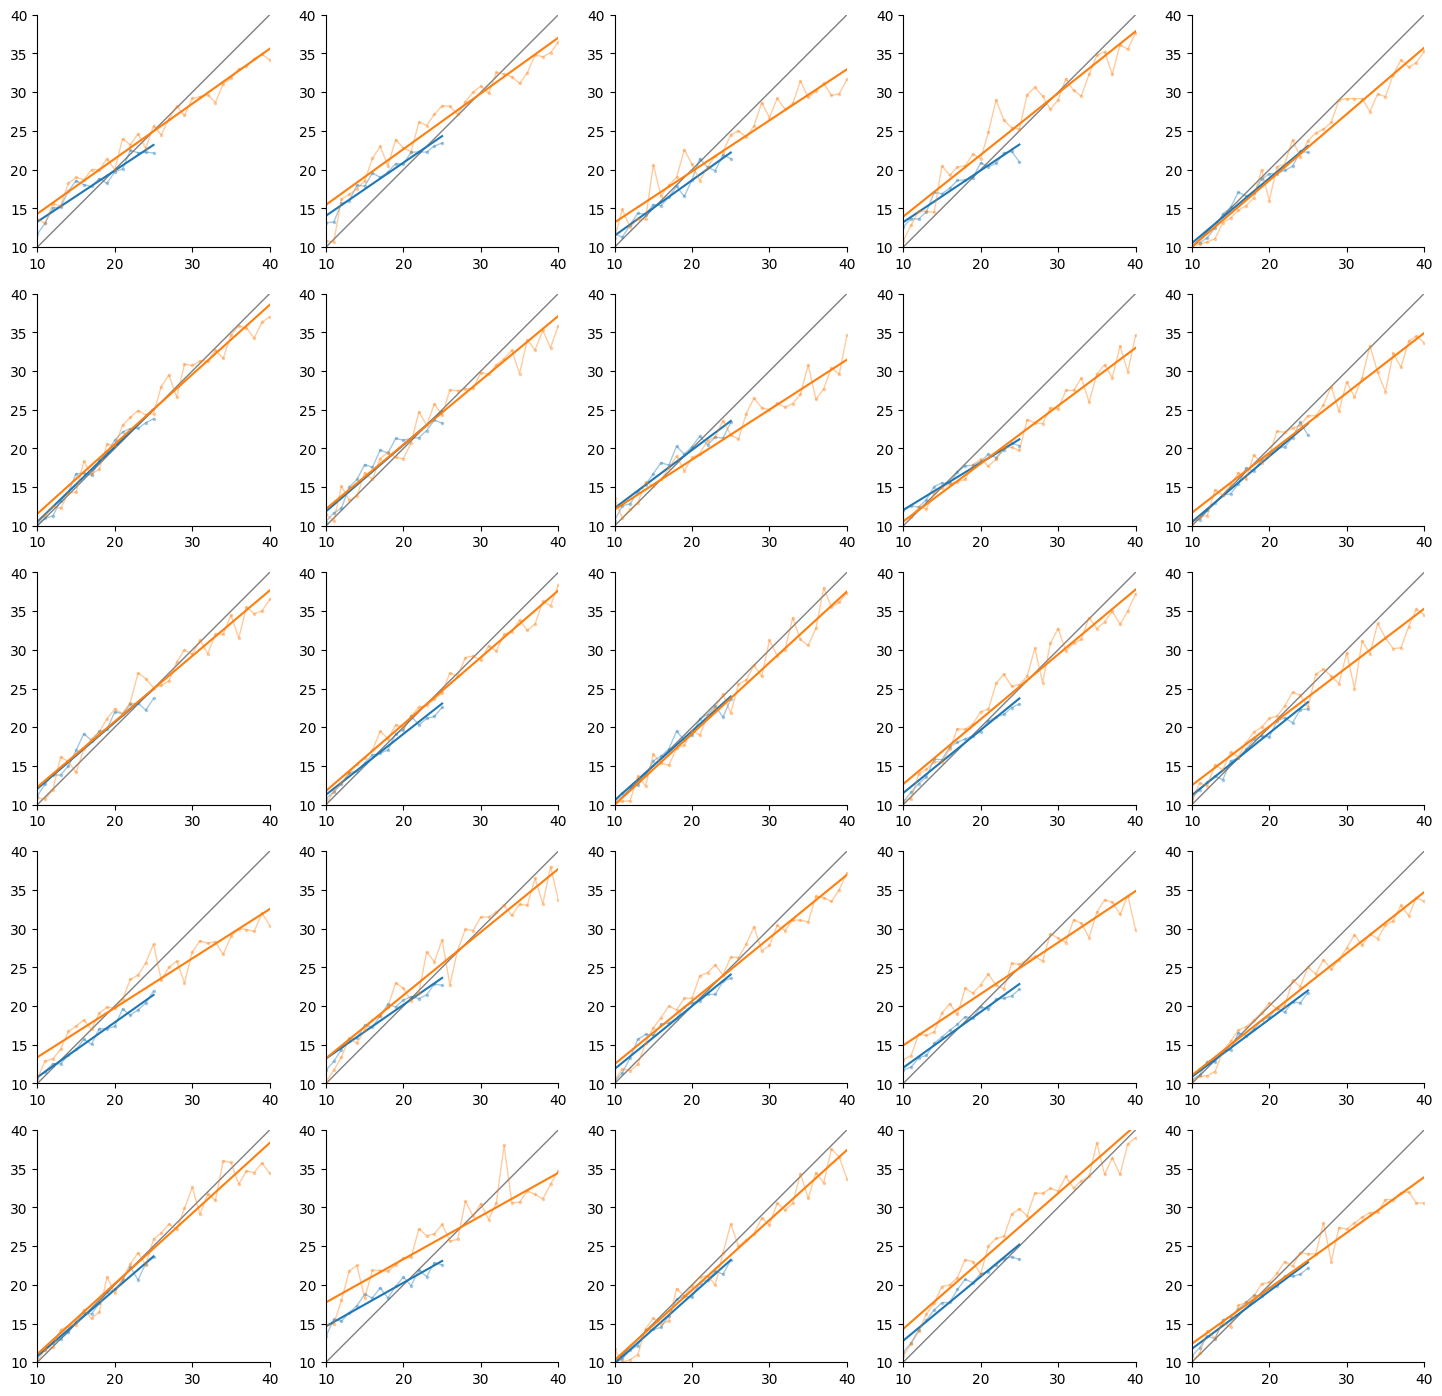

In [15]:
nbSubjs = len(subject_ids)
ncols = 5; nrows = int(np.ceil(nbSubjs/ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18,3.5*np.ceil(nbSubjs/ncols)) )
all_axs = axs.flatten()
for ii,sid in enumerate( subject_ids ):
    ax = all_axs[ii]
    ax.set_aspect(1)
    sdat = beh.loc[sid] #.xs(str(sid).rjust(2, '0'), 0, 'subject')
    for cond in CONDITIONS:
        datC = sdat[sdat.range==cond]
        datC = datC[~pd.isna(datC.response)]
        mresps = estimate_mean_responses_empirical(datC)
        ax.plot(*list(zip(*mresps.items())), c=COLORS_COND[cond], marker='.', ms=5, mec='none', alpha=.4, lw=1)
        mresps = estimate_mean_responses_ols(datC)
        ax.plot(*list(zip(*mresps.items())), c=COLORS_COND[cond], ls='-') #, lw=1)
        #mresps = estimate_mean_responses_gaussian_kernel(datC, conv_w={'narrow':.5, 'wide':1}[cond]*1)
        #ax.plot(*list(zip(*mresps.items())), c=COLORS_COND[cond], ls='-', )
    apc.removeAxSpines(ax)
    ax.axline((10,10), slope=1, c='grey', ls='-', lw=1, zorder=-1000)
    ax.set_xlim(10,40); ax.set_ylim(10,40);
ii += 1
while ii < len(all_axs):
    all_axs[ii].axis('off')
    ii+=1

In [85]:
#pd.DataFrame(columns=pd.MultiIndex.from_product([['narrow', 'wide'], ['A', 7]], names=['range', 'bin_size']), index= )

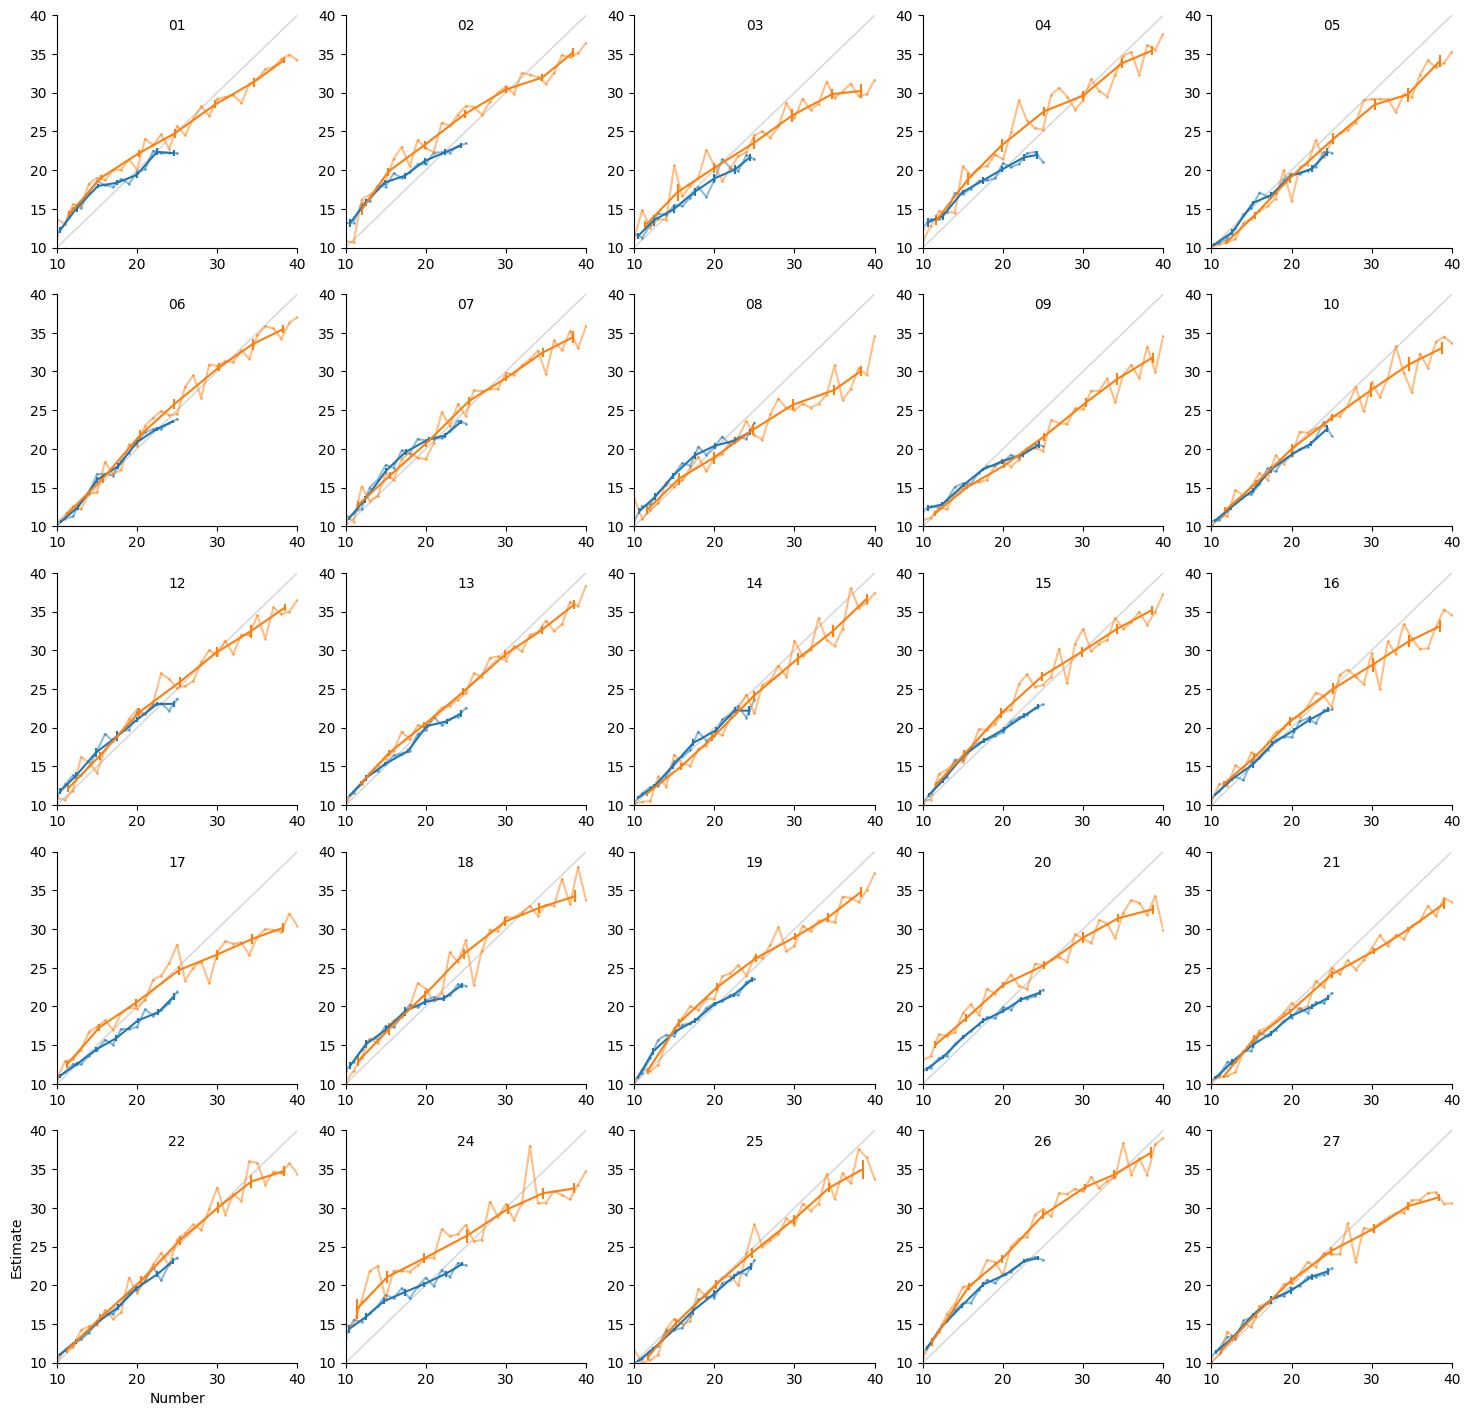

In [110]:
normalize = False
ncols = 5; nrows = int(np.ceil(nbSubjs/ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=int(np.ceil(nbSubjs/ncols)), figsize=(18,3.5*np.ceil(nbSubjs/ncols)) )
all_axs = axs.flatten()
binSizes = ['A', 7]
for ii,sid in enumerate( subject_ids ):
    ax = all_axs[ii]
    for cond in CONDITIONS:
        for k in binSizes:
            ns = binNs[cond][k][ii]
            avgz = binAvgs[cond][k][ii]
            avgz_sem = binAvgs_sem[cond][k][ii]
            if normalize:
                ns = (ns-10)/( 15 if cond=='narrow' else 30 )
            if k=='A':
                ax.plot(ns, avgz, '.-', c=COLORS_COND[cond], alpha=.5, ms=2)
            else:
                ax.errorbar(ns, avgz, yerr=avgz_sem, c=COLORS_COND[cond], label=cond)
    apc.removeAxSpines(ax)
    ax.axline((10,10), slope=1, c='lightgrey', ls='-', lw=1, zorder=-1000)
    ax.set_xlim(0,1) if normalize else ax.set_xlim(10,40)
    ax.set_ylim(10,40)
    ax.set_title(sid, y=.9, fontsize=10)
#axs[0,0].set_xlabel( ('normalized ' if normalize else '') + 'n'); axs[0,0].set_ylabel('response'); 
axs[nrows-1,0].set_xlabel( ('normalized ' if normalize else '') + 'Number'); axs[nrows-1,0].set_ylabel('Estimate'); 
ii += 1
while ii < len(all_axs):
    all_axs[ii].axis('off')
    ii+=1

In [111]:
binNs[cond][k].shape

(25, 7)

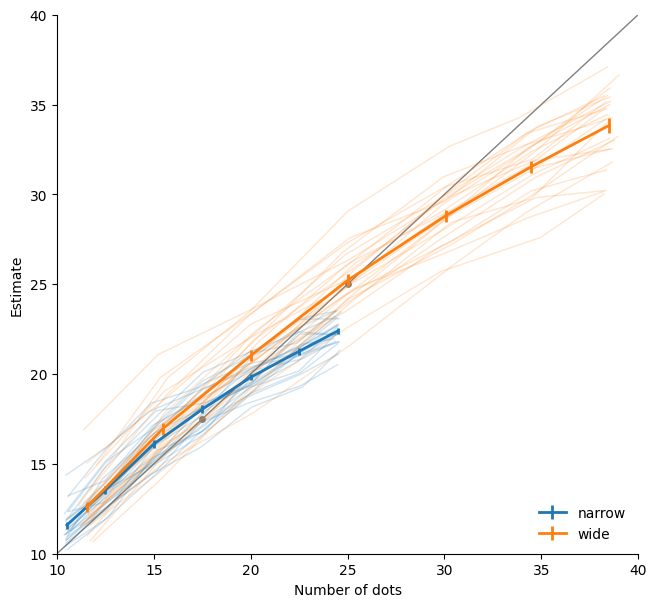

In [112]:
fig, ax = plt.subplots(figsize=(7.5,7))
for cond in CONDITIONS:
    k = 7
    ns = binNs[cond][k] # shape = (nbSubj, k)
    avgzz = binAvgs[cond][k]
    xx = ns.mean(axis=0)
    plt.errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=2)
    #plt.errorbar(xx, np.nanmean(avgzz, axis=0), np.std( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond)
    plt.plot(ns.T, avgzz.T, c=COLORS_COND[cond], lw=1, alpha=.2, zorder=-100)
ax.set_xlabel('Number of dots')
ax.set_ylabel('Estimate')
ax.axline((10,10), slope=1, c='grey', ls='-', lw=1, zorder=-1000)
ax.set_xlim(10,40) if not normalize else ax.set_xlim(0,1);
ax.set_ylim(10,40)
ax.scatter([17.5,25], [17.5,25], s=15, c='grey', zorder=-1000)
apc.removeAxSpines(ax);
ax.legend(loc='lower right');

## Std dev vs Number

Text(0, 0.5, 'Std dev')

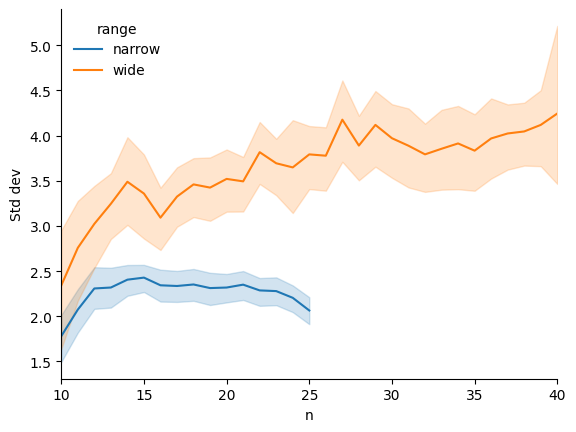

In [93]:
ax = sns.lineplot(x='n', y='response', data=beh, hue='range', estimator='std')
for x in ['top', 'right']: ax.spines[x].set_visible(False);
#ax.plot([41, 80], [41, 80], c='grey', ls='-', lw=1, zorder=-1000)
ax.set_xlim(10,40); #ax.set_ylim(41,80); 
ax.set_ylabel('Std dev')

11.023021845119512 1.4734595870871359e-08
13.986405951810966 3.707906560503684e-17
17.49941495585576 1.5301386444616752e-34
21.2672085799152 1.9837914470367967e-30
25.04581496514089 2.138082549615607e-45
28.486442410542566 5.140738642143497e-30
31.48920852194602 1.7383589283816333e-40


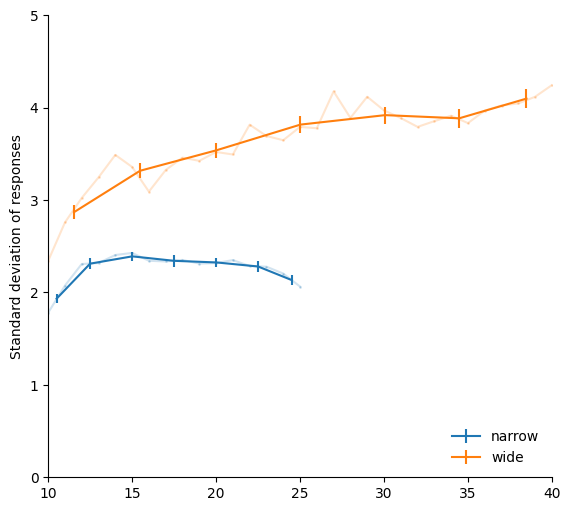

In [94]:
##### this pools all the subjects #####
fig, ax = plt.subplots(figsize=(6.5,6))
binned_excursions_cond = {}
binned_xmean_cond = {}
normalize = 0
for cond in CONDITIONS:
    datC = beh[beh.range==cond]
    datC = datC[~pd.isna(datC.response)]
    #mresps = estimate_mean_responses_gaussian_kernel(datC, conv_w=1.5)
    mresps = estimate_mean_responses_empirical(datC)
    #mresps = estimate_mean_responses_ols(datC)
    datC['excursion'] = datC.apply(axis=1, func=lambda row: row.response - mresps[row.n])
    for k in ['A', 7,]:
        bins_edges = BINS_EDGES[cond][k]
        binned_data = apc.split_in_bins(datC, bin_edges=bins_edges, xs='n')
        xx = np.array( [b.n.mean() for b in binned_data] )
        if normalize:
            xx = (xx-10)/( 15 if cond=='narrow' else 30 )
        if k=='A':
            ax.plot(xx, [b.excursion.std() for b in binned_data], '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            binned_excursions_cond[cond] = [b.excursion for b in binned_data]
            binned_xmean_cond[cond] = xx
            ax.errorbar(xx, [b.excursion.std() for b in binned_data], yerr=[apc.sesd(b.excursion) for b in binned_data], c=COLORS_COND[cond], label=cond)
ax.set_xlabel('Number of dots' + ', normalized' if normalize else '')
ax.set_ylabel('Standard deviation of responses');
ax.set_xlim(10,40) if not normalize else ax.set_xlim(0,1);
ax.set_ylim(0,5)
apc.removeAxSpines(ax);
ax.legend(loc='lower right');
#
xs = []
pvs = []
for i in range(len(binned_xmean_cond[CONDITIONS[0]])):
    x = .5*sum( binned_xmean_cond[cond][i] for cond in CONDITIONS )
    xs.append(x)
    pv = stats.levene(*[binned_excursions_cond[cond][i] for cond in CONDITIONS]).pvalue
    pvs.append(pv)
    print(x, pv)
#pvs = np.array(pvs)
#for x,pv in zip(xs,pvs):
#    ax.text(x,2.0, s='$***$' if pv<=.001 else '$**$' if pv<=0.01 else '$*$' if pv<0.05 else '', ha='center', fontsize=14, usetex=True)

In [99]:
binNs['narrow'][7].mean(axis=0)

array([10.51167715, 12.49765038, 15.00737433, 17.50545328, 20.02060908, 22.49445786, 24.48658488])

In [95]:
binned_xmean_cond

{'narrow': array([10.50599201, 12.4986631 , 15.00723327, 17.51037344, 20.02081448, 22.49551857, 24.49408284]),
 'wide': array([11.54005168, 15.4741488 , 19.99159664, 25.02404372, 30.07081545, 34.47736626, 38.4843342 ])}

['A', 7]


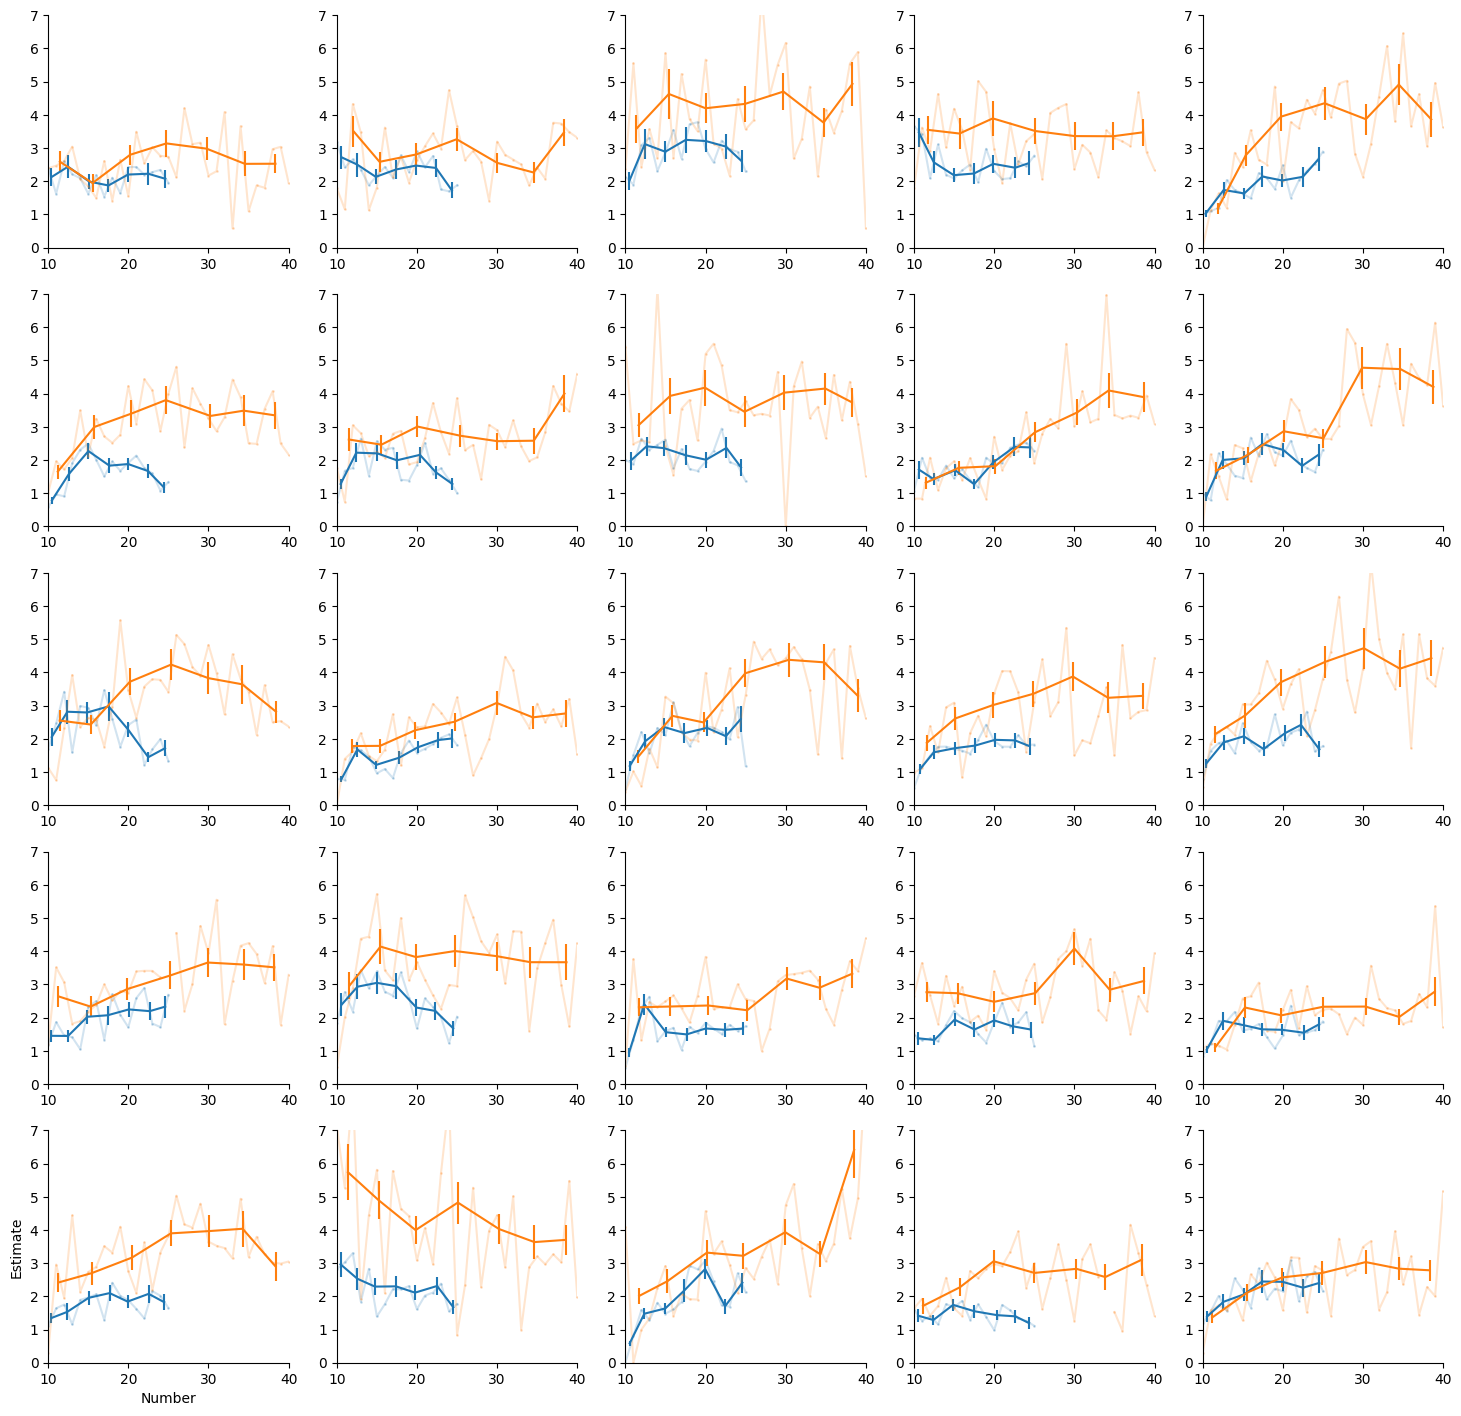

In [113]:
normalize = False
ncols = 5; nrows = int(np.ceil(nbSubjs/ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18,3.5*np.ceil(nbSubjs/ncols)) )
all_axs = axs.flatten()
print(binSizes)
for ii,sid in enumerate( subject_ids ):
    ax = all_axs[ii]
    for cond in CONDITIONS:
        for k in binSizes:
            ns = binNs[cond][k][ii]
            stdz = binStds[cond][k][ii]
            stdz_sesd = binStds_sesd[cond][k][ii]
            if normalize:
                ns = (ns-10)/( 15 if cond=='narrow' else 30 )
            if k=='A':
                ax.plot(ns, stdz, '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
            else:
                ax.errorbar(ns, stdz, yerr=stdz_sesd, c=COLORS_COND[cond], label=cond)
    apc.removeAxSpines(ax)
    #ax.axline((10,10), slope=1, c='grey', ls='-', lw=1, zorder=-1000)
    ax.set_xlim(0,1) if normalize else ax.set_xlim(10,40);
    ax.set_ylim(0,7);
#axs[0,0].set_xlabel( ('normalized ' if normalize else '') + 'n'); axs[0,0].set_ylabel('std dev'); 
axs[nrows-1,0].set_xlabel( ('normalized ' if normalize else '') + 'Number'); axs[nrows-1,0].set_ylabel('Estimate'); 

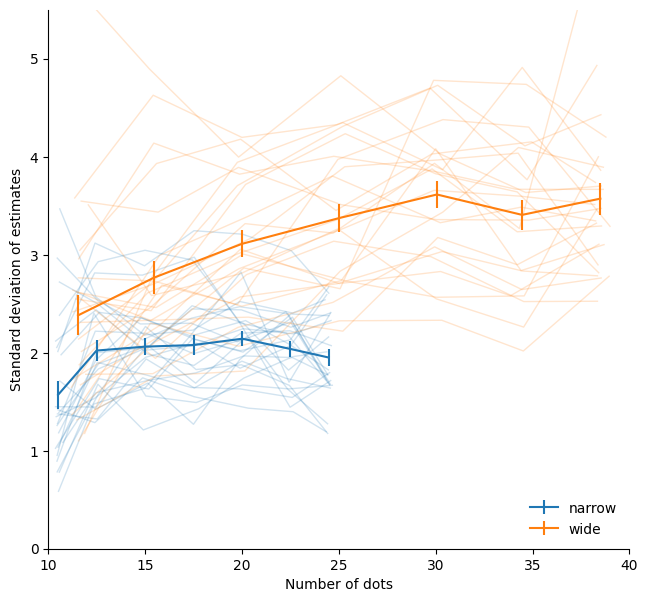

In [115]:
fig, ax = plt.subplots(figsize=(7.5,7))
normalize = False
for cond in CONDITIONS:
    k = 7
    ns = binNs[cond][k] # shape = (nbSubj, k)
    stdzz = binStds[cond][k]
    xx = ns.mean(axis=0)
    if normalize:
        xx = (xx-10)/( 15 if cond=='narrow' else 30 )
    ax.errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
    nns = ( (ns-10)/( 15 if cond=='narrow' else 30 ) ) if normalize else ns
    ax.plot(nns.T, stdzz.T, c=COLORS_COND[cond], lw=1, alpha=.2, zorder=-100)
ax.set_xlabel('Number of dots' + (', normalized' if normalize else '') )
ax.set_ylabel('Standard deviation of estimates');
ax.set_xlim(10,40) if not normalize else ax.set_xlim(0,1);
ax.set_ylim(0,5.5)
apc.removeAxSpines(ax);
ax.legend(loc='lower right');

In [116]:
## for each subject and each condition: all excursions (pooling all the numbers)
excursions_cond = {cond:[] for cond in CONDITIONS}
for ii,sid in enumerate( subject_ids ):
    sdat = beh.loc[sid] #dfAn.xs(str(sid).rjust(2, '0'), 0, 'subject')
    for cond in CONDITIONS:
        datC = sdat[sdat.range==cond]
        datC = datC[~pd.isna(datC.response)]
        mresps = estimate_mean_responses_ols(datC)
        #mresps = estimate_mean_responses_empirical(datC)
        #mresps = estimate_mean_responses_gaussian_kernel(datC, conv_w={'narrow':.5, 'wide':1}[cond]*2)
        excursions = datC.apply(axis=1, func=lambda row: row.response - mresps[row.n])
        excursions_cond[cond].append( excursions.values )
stdz_cond = {cond:np.array([e.std() for e in excursions]) for cond,excursions in excursions_cond.items()}

In [117]:
def odr_1dregression(x, y, data=None):
    if data is None:
        dat = odr.Data(x, y)
    else:
        dat = odr.Data(data[x], data[y])
    myodr = odr.ODR(dat, odr.unilinear, beta0=[1., 0.]) # start point = identity
    res = myodr.run()
    return res

def odr_pred(odr_res, x):
    B = odr_res.beta
    return B[0]*x + B[1]

Beta: [ 2.09900457 -1.01965009]
Beta Std Error: [0.47826041 1.00218113]
Beta Covariance: [[ 3.56291517 -7.41421299]
 [-7.41421299 15.64476581]]
Residual Variance: 0.0641982771302711
Inverse Condition #: 0.005385093797237928
Reason(s) for Halting:
  Sum of squares convergence


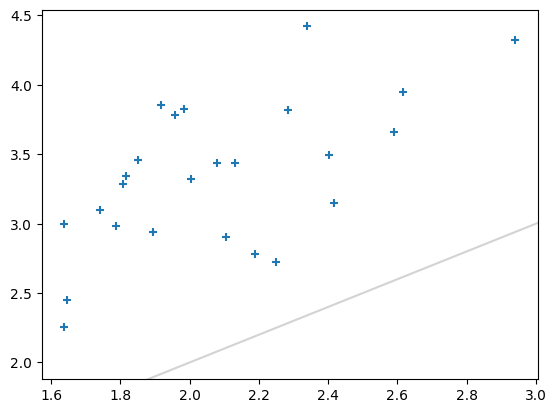

In [118]:
res = odr_1dregression(stdz_cond['narrow'], stdz_cond['wide']); res.pprint()
plt.scatter( stdz_cond['narrow'], stdz_cond['wide'], marker='+') 
plt.axline((2,2), slope=1, c='lightgrey')

Text(0.5, 0, 'Number')

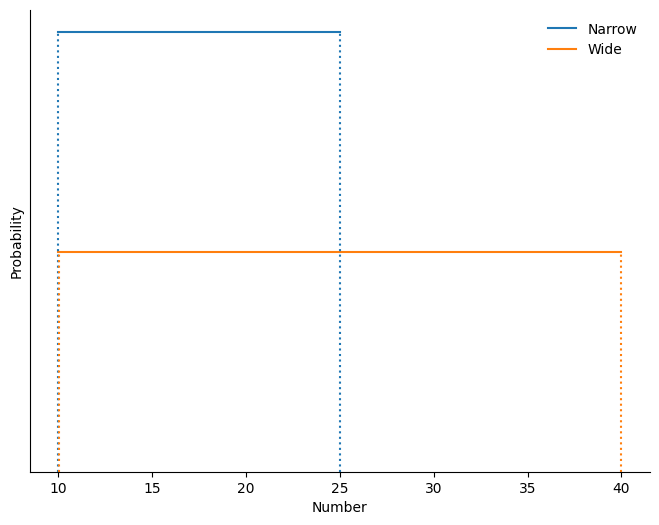

In [119]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot([10, 25], [1/15, 1/15], c=COLORS_COND['narrow'], label='Narrow')
ax.plot([10, 40], [1/30, 1/30], c=COLORS_COND['wide'], label='Wide')
ax.plot([10-.04,10-.04], [0, 1/15], c=COLORS_COND['narrow'], ls=':'); ax.plot([25,25], [0, 1/15], c=COLORS_COND['narrow'], ls=':')
ax.plot([10+.04,10+.04], [0, 1/30], c=COLORS_COND['wide'], ls=':');   ax.plot([40,40], [0, 1/30], c=COLORS_COND['wide'], ls=':')
ax.set_ylim(0,None)
apc.removeAxSpines(ax)
ax.legend()
ax.set_yticks([])
ax.set_ylabel('Probability')
ax.set_xlabel('Number')

## Intersection bias=0

$mx + c = x$ if $x=\frac{c}{1-m}$

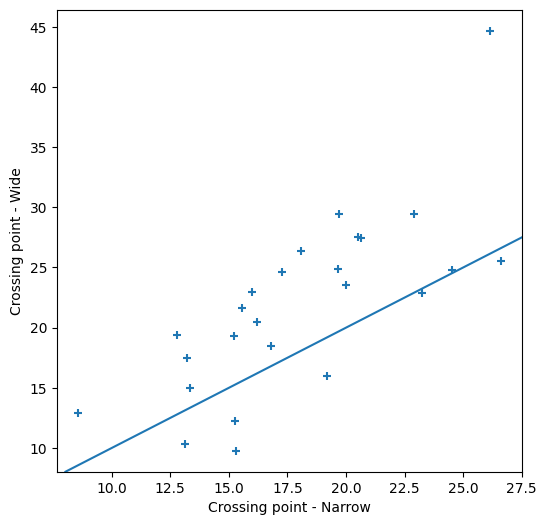

In [121]:
fig, ax = plt.subplots(figsize=(6,6))
cross_idline = {'narrow':[], 'wide':[]}
slopes = {'narrow':[], 'wide':[]}
for ii,sid in enumerate( subject_ids ):
    sdat = beh.loc[sid] #dfAn.xs(str(sid).rjust(2, '0'), 0, 'subject')
    for cond in CONDITIONS:
        datC = sdat[sdat.range==cond]
        datC = datC[~pd.isna(datC.response)]
        mresps, (m,c) = estimate_mean_responses_ols(datC, return_pars=True)
        cross_idline[cond].append(c/(1-m))
        slopes[cond].append(m)
ax.scatter( cross_idline['narrow'], cross_idline['wide'], marker='+' )
ax.set_xlabel('Crossing point - Narrow')
ax.set_ylabel('Crossing point - Wide')
stats.pearsonr( cross_idline['narrow'], cross_idline['wide'] )
ax.axline((15,15), slope=1)

In [122]:
slopes

{'narrow': [0.6613567283423863,
  0.6858054532377236,
  0.7151933580948223,
  0.6688754976631478,
  0.8373527644424922,
  0.9681747179289643,
  0.8582880277617126,
  0.7497946013430088,
  0.6083671824087212,
  0.8484239214983526,
  0.8575624931382637,
  0.7853608274486124,
  0.8945962505822468,
  0.814199677199835,
  0.8020424143556285,
  0.7081291176903329,
  0.6942133283394422,
  0.8131758084769889,
  0.7205572947921718,
  0.7431975114382224,
  0.859854876470975,
  0.5627890326492742,
  0.8909168517528971,
  0.8277623704568678,
  0.7453546129442621],
 'wide': [0.7098699028473456,
  0.7191417038453372,
  0.6590002634874912,
  0.7969476193809382,
  0.8565919477572805,
  0.8992118494182927,
  0.830899831599372,
  0.6449699284241758,
  0.7475457300915921,
  0.7736142464323454,
  0.845826750569018,
  0.8628974506543481,
  0.9181255556315381,
  0.8373548760865043,
  0.7600341753458124,
  0.6375177025050495,
  0.8153710461060817,
  0.8146477210081055,
  0.6642113513632373,
  0.7885591950218

## Error

narrow
nan
wide
nan


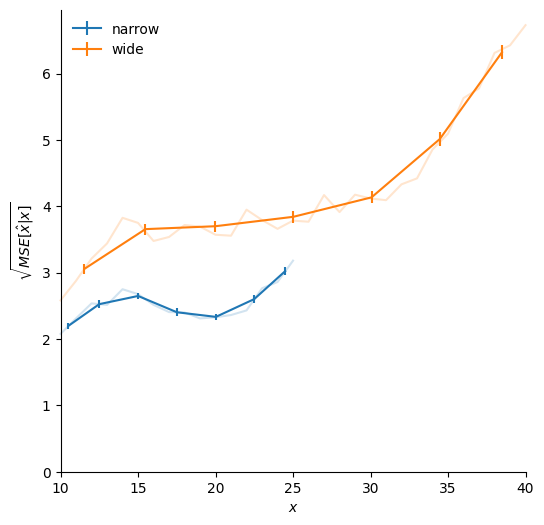

In [30]:
fig, ax = plt.subplots(ncols=1, figsize=(6,6))
binned_errs_cond = {}
for k in ['A', 7,]:
    for cond in CONDITIONS:
        bin_edges = BINS_EDGES[cond][k]
        da = beh[beh.range==cond]
        binned_data = apc.split_in_bins(da, bin_edges, xs=da.n)
        binned_errors = apc.split_in_bins(da.error, bin_edges=bin_edges, xs=da.n)
        binned_errs_cond[cond] = binned_errors
        mses = np.array( [ (errs**2).mean() for errs in binned_errors] )
        sqrt_mses = np.sqrt(mses)
        se_sqrt_mses = np.array( [ apc.sesd(errs) for errs in binned_errors] ) ### Correct???
        xs = np.array([_da.n.mean() for _da in binned_data])
        c = COLORS_COND[cond]
        if k=='A':
            ax.plot(xs, sqrt_mses, c=c, alpha=.2, clip_on=False)
        else:
            ax.errorbar(xs, sqrt_mses, se_sqrt_mses, label=cond)
            print(cond)
            print(stats.levene( binned_errors[2], binned_errors[-1] ).pvalue)
#ax.axline((60,60), slope=1, c='lightgrey', zorder=-1000)
ax.set_xlim(10,40); ax.set_ylim(0,None);
apc.removeAxSpines(ax)
ax.legend()
ax.set_xlabel('$x$'); ax.set_ylabel('$\sqrt{MSE[\hat x|x]}$');

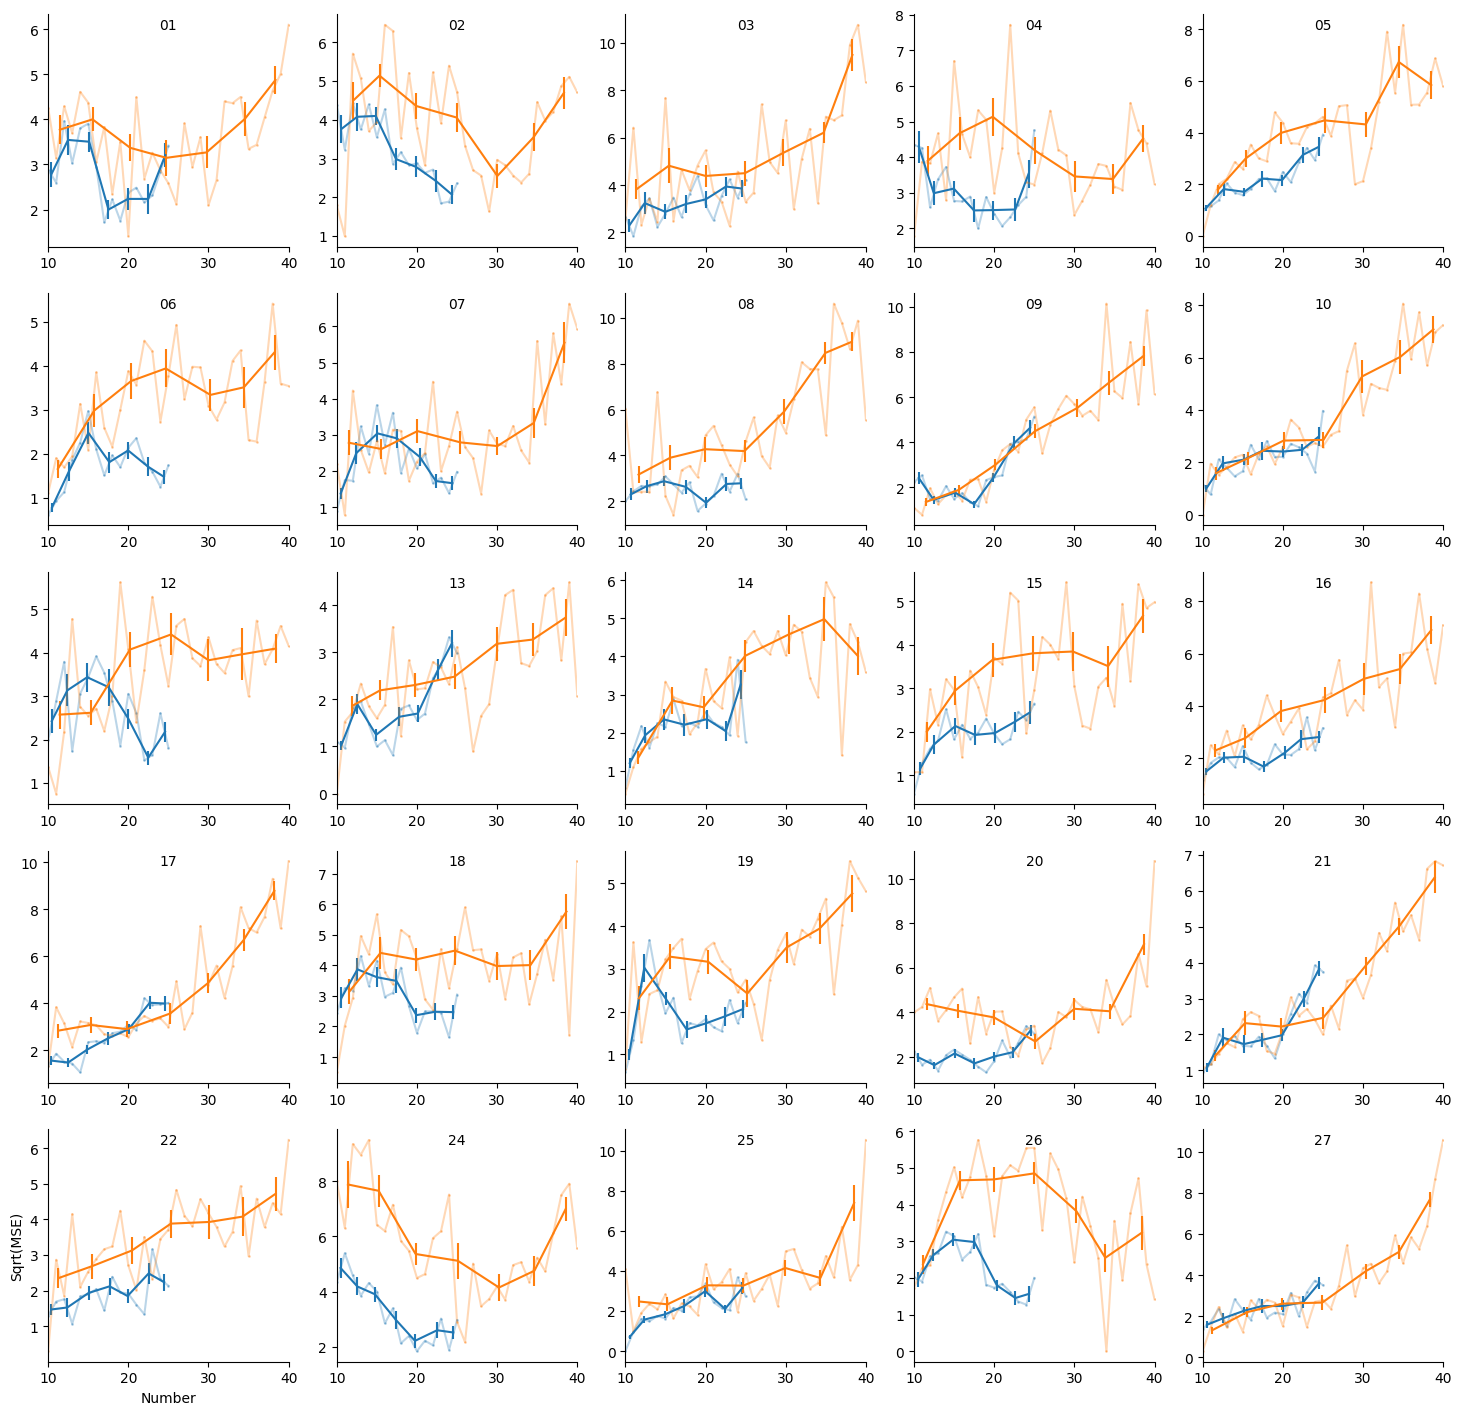

In [127]:
normalize = False
ncols = 5; nrows = int(np.ceil(nbSubjs/ncols))
fig, axs = plt.subplots(ncols=ncols, nrows=int(np.ceil(nbSubjs/ncols)), figsize=(18,3.5*np.ceil(nbSubjs/ncols)) )
all_axs = axs.flatten()
binSizes = ['A', 7]
for ii,sid in enumerate( subject_ids ):
    ax = all_axs[ii]
    for cond in CONDITIONS:
        for k in binSizes:
            ns = binNs[cond][k][ii]
            sqrt_msez = binSqrtMses[cond][k][ii]
            sqrt_msez_se = binSqrtMses_se[cond][k][ii]
            if normalize:
                ns = (ns-10)/( 15 if cond=='narrow' else 30 )
            if k=='A':
                ax.plot(ns, sqrt_msez, '.-', c=COLORS_COND[cond], alpha=.3, ms=2)
            else:
                ax.errorbar(ns, sqrt_msez, yerr=sqrt_msez_se, c=COLORS_COND[cond], label=cond)
    apc.removeAxSpines(ax)
    ax.set_xlim(0,1) if normalize else ax.set_xlim(10,40)
    ax.set_title(sid, y=.9, fontsize=10)
#axs[0,0].set_xlabel( ('normalized ' if normalize else '') + 'n'); axs[0,0].set_ylabel('response'); 
axs[nrows-1,0].set_xlabel( ('normalized ' if normalize else '') + 'Number'); axs[nrows-1,0].set_ylabel('Sqrt(MSE)'); 
ii += 1
while ii < len(all_axs):
    all_axs[ii].axis('off')
    ii+=1

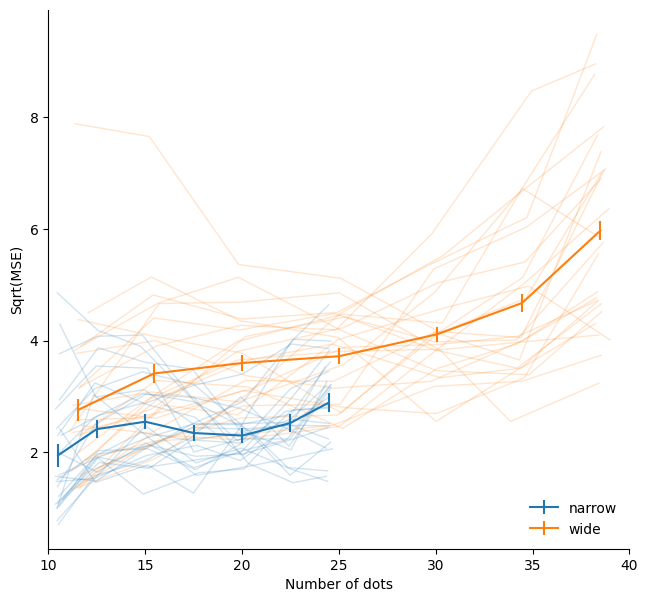

In [129]:
fig, ax = plt.subplots(figsize=(7.5,7))
normalize = False
for cond in CONDITIONS:
    k = 7
    ns = binNs[cond][k] # shape = (nbSubj, k)
    sqrt_msez = binSqrtMses[cond][k]
    xx = ns.mean(axis=0)
    if normalize:
        xx = (xx-10)/( 15 if cond=='narrow' else 30 )
    ax.errorbar(xx, np.nanmean(sqrt_msez, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
    nns = ( (ns-10)/( 15 if cond=='narrow' else 30 ) ) if normalize else ns
    ax.plot(nns.T, sqrt_msez.T, c=COLORS_COND[cond], lw=1, alpha=.2, zorder=-100)
ax.set_xlabel('Number of dots' + (', normalized' if normalize else '') )
ax.set_ylabel('Sqrt(MSE)');
ax.set_xlim(10,40) if not normalize else ax.set_xlim(0,1);
#ax.set_ylim(0,5.5)
apc.removeAxSpines(ax);
ax.legend(loc='lower right');

# A closer look at the variability at the boundaries

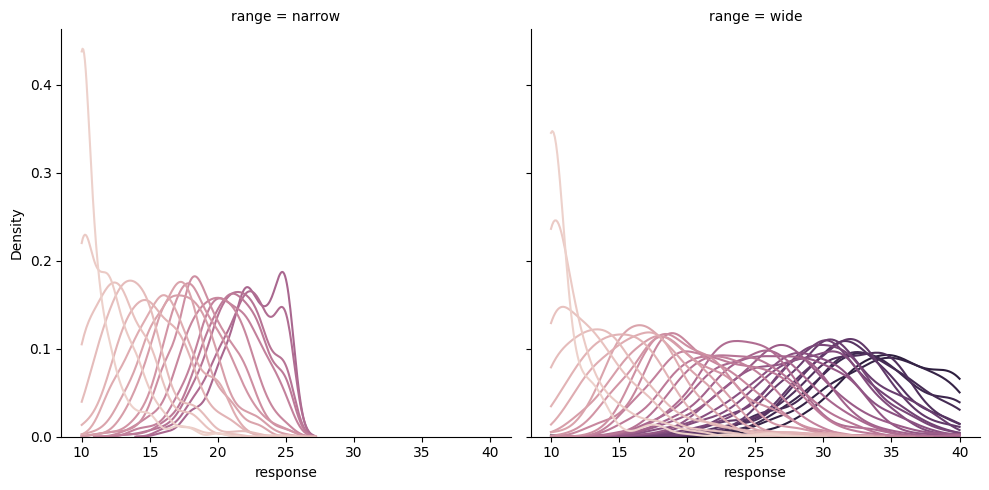

In [580]:
g = sns.displot(beh, kind='kde', x='response', hue='n', col='range', clip=(10,40),
                legend=False, fill=False, common_norm=False, bw_adjust=1) # clip=(41,80), bw_adjust=1.2)
#[ax.set_xlim(41,80) for ax in g.axes[0]]

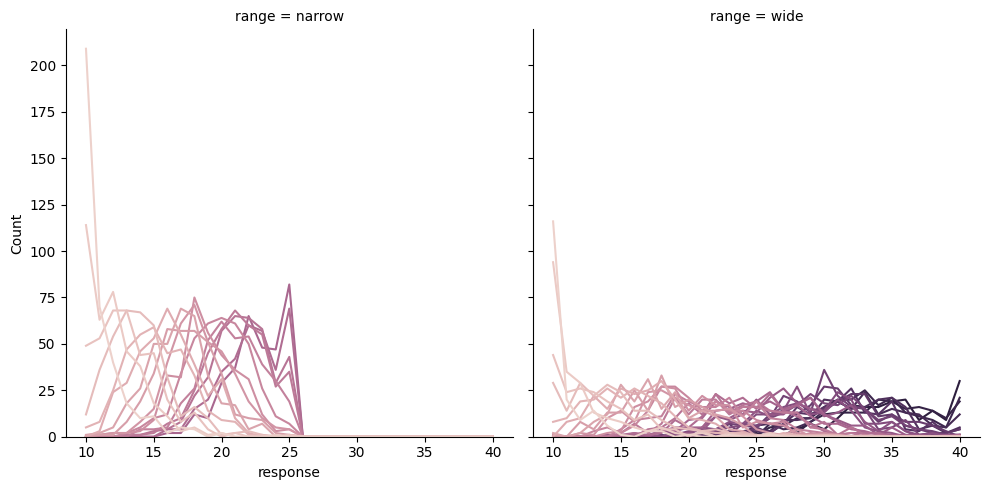

In [563]:
g = sns.displot(beh, kind='hist', x='response', hue='n', col='range', bins=np.arange(9.5, 41.5, 1), element='poly', 
                legend=False, fill=False, common_norm=False,) # clip=(41,80), bw_adjust=1.2)
#[ax.set_xlim(41,80) for ax in g.axes[0]]

In [581]:
stats.truncnorm.fit

<bound method rv_continuous.fit of <scipy.stats._continuous_distns.truncnorm_gen object at 0x16c0d2a10>>

25 3.791994350818644
36 3.9682846517675436
37 4.023426125852496
38 4.045818547276302
39 4.118174422773015
40 4.244116282603226


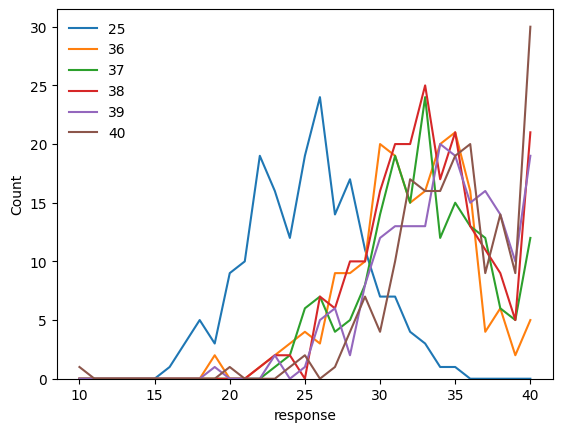

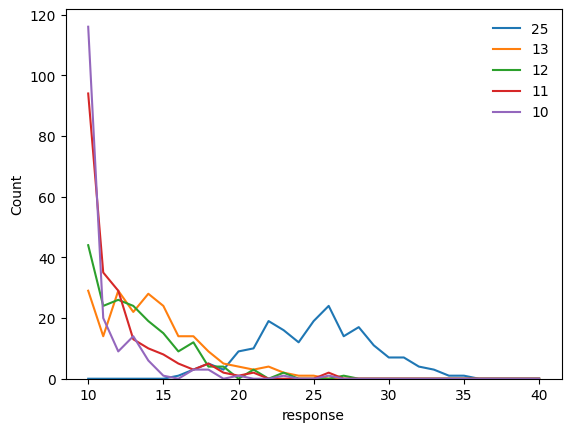

In [725]:
for n in [25, 36, 37, 38, 39, 40]:
    dat = beh[ (beh['range']=='wide') & (beh['n']==n) ]
    #plt.hist(dat.response, histtype='step', bins=np.arange(9.5, 41.5))
    sns.histplot(data=dat, x='response', element='poly', fill=False, bins=np.arange(9.5, 41.5), label=n)
    print( n, dat.response.std() )
plt.legend()
plt.figure()
for n in reversed([10, 11, 12, 13, 25]):
    dat = beh[ (beh['range']=='wide') & (beh['n']==n) ]
    #plt.hist(dat.response, histtype='step', bins=np.arange(9.5, 41.5))
    sns.histplot(data=dat, x='response', element='poly', fill=False, bins=np.arange(9.5, 41.5), label=n)
plt.legend()

In [ ]:
sns.histplot()

In [548]:
beh

onset  phase  response  nr_frames     n  jitter  start_marker_position  response_time   onset_abs  duration   range  error  \
subject session run trial_nr                                                                                                                                    
01      1       1   1          68.826307      5       NaN       30.0  11.0     6.0                   24.0            NaN   76.378611  0.500457  narrow    NaN   
                    2          76.016292      5      19.0       31.0  23.0     4.0                   14.0       1.317963   83.568595  0.517188  narrow   -4.0   
                    3          87.026471      5      25.0       30.0  23.0     6.0                   11.0       0.834244   94.578775  0.500469  narrow    2.0   
                    4          97.085656      5      24.0       30.0  22.0     5.0                   22.0       1.701381  104.637959  0.500559  narrow    2.0   
                    5         106.744768      5      17.0       31.0  21.0     5.0                   22.0       2.018881  114.297072  0.517009  narrow   -4.0   
...                                  ...    ...       ...        ...   ...     ...                    ...            ...         ...       ...     ...    ...   
27      2       8   26        280.689830      5      22.0       30.0  20.0     6.0                   23.0       1.384728  284.091391  0.500461  narrow    2.0   
                    27        290.448877      5      23.0       31.0  24.0     4.0                   22.0       1.951233  293.850438  0.517034  narrow   -1.0   
                    28        301.041931      5      23.0       30.0  21.0     6.0                   12.0       1.051049  304.443492  0.500531  narrow    2.0   
                    29        308.999370      5      14.0       30.0  10.0     4.0                   22.0       1.635088  312.400931  0.500508  narrow    4.0   
                    30        318.875303      5      21.0       30.0  18.0     5.0                   11.0       0.500447  322.276864  0.500352  narrow    3.0   

                              abs_error  squared_error  
subject session run trial_nr                            
01      1       1   1               NaN            NaN  
                    2               4.0           16.0  
                    3               2.0            4.0  
                    4               2.0            4.0  
                    5               4.0           16.0  
...                                 ...            ...  
27      2       8   26              2.0            4.0  
                    27              1.0            1.0  
                    28              2.0            4.0  
                    29              4.0           16.0  
                    30              3.0            9.0  

[12000 rows x 14 columns]

# Model(s)

In [32]:
import numerosity.numerosity as num

In [33]:
def min_objf(f, x0s, v=True, return_all_res=False, **kwargs):
    bestF = np.inf
    bestRes = None
    if return_all_res:
        all_res = []
    for x0 in x0s:
        #try:
        res = optimize.minimize(f, x0=x0, **kwargs)
        #except Exception as e:
        #    print('!!', x0, 'threw an exception.')
        #    print(e)
        #    continue
        if v:
            print(x0, '->', res.x, res.fun)
        if res.fun < bestF:
            bestF = res.fun
            bestRes = res
        if return_all_res:
            all_res.append(res)
    if return_all_res:
        return bestRes, all_res
    return bestRes

In [34]:
import itertools

In [35]:
XS_COND = {
    'narrow' : np.arange(10, 26, 1),
    'wide'   : np.arange(10, 41, 1),
}
for xs in XS_COND.values():
    xs.flags.writeable = False
PRIORS_COND = {
    'narrow' : np.ones(16)/16.,
    'wide'   : np.ones(31)/31.,
}
for pxs in PRIORS_COND.values():
    pxs /= pxs.sum()
    pxs.flags.writeable = False
WIDTHS_COND = { 'narrow':15, 'wide':30 }

In [36]:
def μxs_and_ν_from_Ixs(Ixs, dx=1):
    '''Given Fisher information Ixs, returns μxs ranging from 0 to 1, together with noise parameter ν,
    such that a Gaussian r.v. with mean μ(x) and std dev ν has Fisher information I(x).
    `dx` is used for integration. The defaut dx=1 assumes that Ixs is defined for an array of numbers separated by 1 (e.g., integers).'''
    sqrtIxs = np.sqrt(Ixs)
    sqrtIxs = (sqrtIxs[1:]+sqrtIxs[:-1])/2 # we do this because sqrt(I(x)) is the derivative of μ(x), and μ(x) is set to 0 at the first x.
    ν = 1/( np.sum(sqrtIxs)*dx )
    μxs = np.r_[0, ν * np.cumsum(sqrtIxs) * dx]
    return μxs, ν

def opt_Ixs_μxs_and_ν(spxs, θcost, dx=1):
    '''Given a subjective prior spxs and a cost parameter θcost, returns the optimal Fisher information Ixs, along with μxs and ν (see`μxs_and_ν_from_Ixs`).
    `dx` is used for integration. The defaut dx=1 assumes that spxs is defined for an array of numbers separated by 1 (e.g., integers).'''
    if θcost==0:
        return np.ones_like(spxs)*np.inf, np.linspace(0,1,len(spxs)), 0.
    Ixs = (spxs**(2/3)) / np.sqrt( θcost * (spxs**(1/3)).sum() * dx )
    μxs, ν = μxs_and_ν_from_Ixs(Ixs, dx=dx)
    return Ixs, μxs, ν

In [131]:
# with uniform priors ν should be θ^(1/4) / sqrt(width)
θcost = 10.5
opt_Ixs_μxs_and_ν(PRIORS_COND['wide'], θcost)[2], θcost**(1/4)/( np.sqrt(30)  )

(0.3340849539751527, 0.32865231624539687)

narrow 0.26666666666666666 1.0
wide 0.18559214542766744 0.9999999999999997


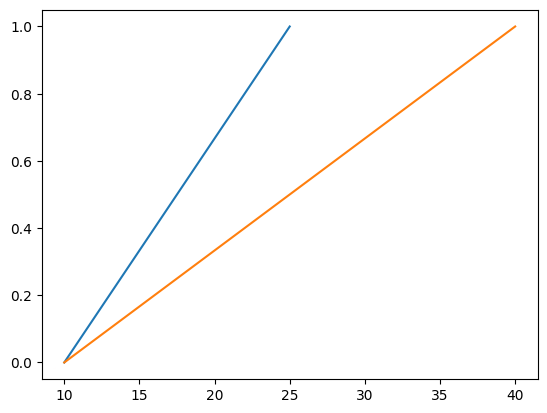

In [132]:
for cond in CONDITIONS:
    pxs = PRIORS_COND[cond]
    θcost = 1
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(pxs, θcost)
    xs = XS_COND[cond]
    plt.plot(xs, μxs, c=COLORS_COND[cond])
    print(cond, ν, μxs[-1])

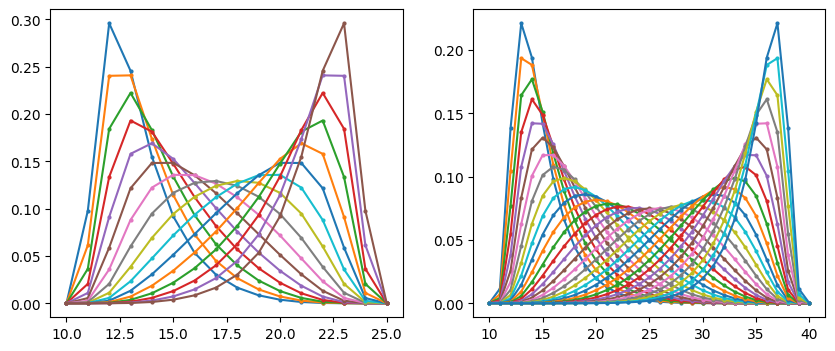

In [133]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    pxs = PRIORS_COND[cond]
    θcost = 1
    σ = 0
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(pxs, θcost)    
    pxhatx = num.probs_xhats_given_x_with_μxs(xs, pxs, μxs, ν=ν, σ=σ, NUM_RS=100_000)
    axs[ic].plot(xs, pxhatx.T, 'o-', ms=2)

In [134]:
subject_ids

Index(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '24', '25', '26', '27'], dtype='object', name='subject')

In [242]:
def model_predictions(sxs, spxs, μxs, ν, σ, correct_xs=None, NUM_RS=100_000):
    if correct_xs is None: correct_xs = sxs
    pxhatx = num.probs_xhats_given_x_with_μxs(sxs, spxs, μxs, ν=ν, σ=σ, lo=correct_xs[0], w=correct_xs[-1]-correct_xs[0], NUM_RS=NUM_RS)
    pxhatx = pxhatx[ np.isin(sxs, correct_xs) ]
    #print(pxhatx.shape)
    avg_ests = (pxhatx*correct_xs).sum(axis=1)
    #print(avg_ests.shape)
    stddev_ests = np.sqrt( (pxhatx*(xs-avg_ests[...,np.newaxis])**2).sum(axis=1) )
    return pxhatx, avg_ests, stddev_ests

(0.0, 3.8704775223536454)

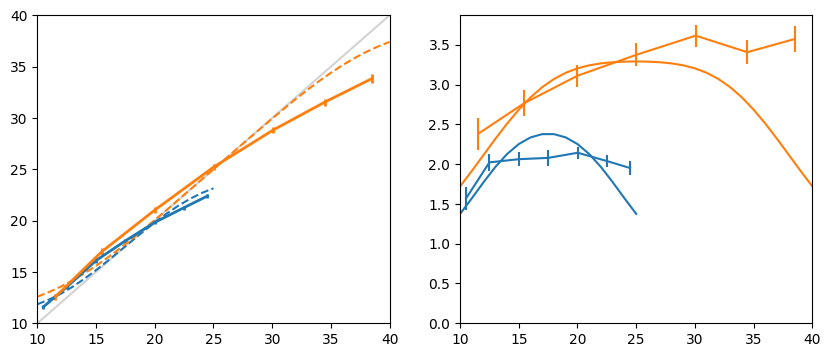

In [135]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    pxs = PRIORS_COND[cond]
    θcost = .1
    σ = 1
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(pxs, θcost)
    pxhatx, avg_ests, stddev_ests = model_predictions(xs, pxs, μxs, ν=ν, σ=σ, NUM_RS=100_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond])
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=2)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

In [42]:
θcost = .01
Ixs, μxs, ν_n = opt_Ixs_μxs_and_ν(PRIORS_COND['narrow'], θcost=θcost)
Ixs, μxs, ν_w = opt_Ixs_μxs_and_ν(PRIORS_COND['wide'], θcost=θcost)
ν_n, ν_w, ν_w*np.sqrt(2)

(0.08432740427115679, 0.058689389538863365, 0.08299933065325822)

## Likelihood

In [43]:
def mLL(dat, sxs, spxs, μxs, ν, σ, w, lo=10, NUM_RS=10_000):
    #print( ν, σ, w )
    pxhatx = num.probs_xhats_given_x_with_μxs(sxs, spxs, μxs, ν=ν, σ=σ, lo=lo, w=w, NUM_RS=NUM_RS)
    #print(pxhatx)
    pxhatx_onsupport = pxhatx[(sxs>=lo) & (sxs<=(lo+w))]
    logpxhatx = np.where(pxhatx_onsupport>0, pxhatx_onsupport, -np.inf)
    np.log(logpxhatx, out=logpxhatx, where=logpxhatx>0)
    #print(logpxhatx)
    return -logpxhatx[dat.n.astype(int)-lo,dat.response.astype(int)-lo].sum()

In [45]:
def mLL_with_ν(dat, cond, ν, σ, NUM_RS=10_000): # straightfoward with ν
    xs = XS_COND[cond]
    pxs = PRIORS_COND[cond]
    correct_w = WIDTHS_COND[cond]
    dat_ = dat[dat.range==cond]
    μxs = np.linspace(0, 1, len(xs))
    return mLL(dat_, xs, pxs, μxs, ν, σ, w=correct_w, lo=10, NUM_RS=NUM_RS)

def mLL_with_θ(dat, cond, θcost, σ, NUM_RS=10_000):
    w = WIDTHS_COND[cond]
    ν = θcost**(1/4) / np.sqrt(w)
    return mLL_with_ν(dat, cond, ν, σ, NUM_RS=NUM_RS)


In [46]:
from functools import cache

In [47]:
@cache
def mLL_allsubjects_with_ν(cond, ν, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)]
    return mLL_with_ν(dat, cond, ν, σ, NUM_RS=NUM_RS) 
@cache
def mLL_onesubject_with_ν(sid, cond, ν, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)].loc[sid]
    return mLL_with_ν(dat, cond, ν, σ, NUM_RS=NUM_RS) 

In [48]:
mLL_allsubjects_with_ν('narrow', ν=0, σ=3)

12958.393507244822

In [49]:
mLL_onesubject_with_ν('07', 'narrow', ν=0, σ=3)

511.60920044557497

## No-cognitive-noise model

Model: $\nu=0$, $\sigma$ different in each condition.  
This can also be seen as a way to measure the overall noise separately in each condition.

In [136]:
def objf_nocognoise(x):
    σ_n, σ_w = x
    r  = mLL_allsubjects_with_ν('narrow', ν=0, σ=σ_n)
    r += mLL_allsubjects_with_ν('wide', ν=0, σ=σ_w)
    #print(x, r)
    return r
respooled_nocognoise = optimize.minimize(objf_nocognoise, x0=[3, 3], bounds=[(0.,None),]*2)
print(respooled_nocognoise)
####### Per subject
def objf_nocognoise_onesubj(x, sid):
    σ_n, σ_w = x
    r  = mLL_onesubject_with_ν(sid, 'narrow', ν=0, σ=σ_n)
    r += mLL_onesubject_with_ν(sid, 'wide', ν=0, σ=σ_w)
    #print(x, r)
    return r
results_nocognoise = []
for sid in subject_ids:
    res = optimize.minimize(objf_nocognoise_onesubj, x0=[3, 3], args=(sid,), bounds=[(0.,None),]*2)
    if not res.success:
        print('!', sid)
        print(res)
    results_nocognoise.append([sid, res.x[0], res.x[1], res.fun])
results_nocognoise = pd.DataFrame(results_nocognoise, columns=['subject', 'sigma_n', 'sigma_w', 'mll'])
print('-LL =', results_nocognoise['mll'].sum() )
results_nocognoise


  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 29007.610675334014
        x: [ 2.766e+00  4.665e+00]
      nit: 7
      jac: [ 0.000e+00  0.000e+00]
     nfev: 24
     njev: 8
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
-LL = 28626.415565605235


subject   sigma_n   sigma_w          mll
0       01  3.098263  4.063359  1144.541639
1       02  3.713269  4.551815  1222.719136
2       03  3.736999  6.325157  1248.600036
3       04  3.487110  4.546494  1186.030894
4       05  2.372351  4.933552  1158.251398
5       06  1.942789  3.671270  1068.005608
6       07  2.549503  3.407594  1110.139683
7       08  2.870104  6.932362  1184.679525
8       09  3.046475  5.529635  1224.307946
9       10  2.440000  4.678000  1141.537451
10      12  2.945730  3.998997  1145.834618
11      13  2.076322  2.843802  1034.729056
12      14  2.378718  3.946282  1084.967525
13      15  2.120736  3.848290  1030.629598
14      16  2.289606  4.958978  1130.993795
15      17  3.059955  5.730234  1220.159519
16      18  3.465986  4.608948  1194.055953
17      19  2.173508  3.660041  1074.216649
18      20  2.275852  4.835550  1147.370614
19      21  2.511555  3.832411  1105.370655
20      22  2.093698  3.749251  1082.676390
21      24  3.897581  6.848209  1267.499473
22      25  2.423903  4.344702  1127.741772
23      26  2.575042  4.324674  1136.320994
24      27  2.720087  4.680673  1155.035639

In [52]:
results_nocognoise['sigmaSq_n'] = results_nocognoise.sigma_n**2
results_nocognoise['sigmaSq_w'] = results_nocognoise.sigma_w**2

In [53]:
results_nocognoise.mll.sum()

28626.415565605235

Subject $i$, prior $1$: $var_{i1} = \sigma_{i}^2 + w_1 \nu_i$  
Subject $i$, prior $2$: $var_{i2} = \sigma_{i}^2 + w_2 \nu_i$  
Thus $\nu_i = (var_{i2} - \sigma_{i}^2)/w_2$, and $var_{i1} = \sigma_{i}^2 + (var_{i2} - \sigma_{i}^2)w_1/w_2 = \sigma_{i}^2 (1-w_1/w_2) + var_{i2} w_1/w_2$  

Beta: [  4.84294597 -15.53157213]
Beta Std Error: [ 1.27317079 10.24979257]
Beta Covariance: [[ 0.22320069 -1.73508588]
 [-1.73508588 14.46612964]]
Residual Variance: 7.262360452154686
Inverse Condition #: 0.0032018648831119486
Reason(s) for Halting:
  Sum of squares convergence


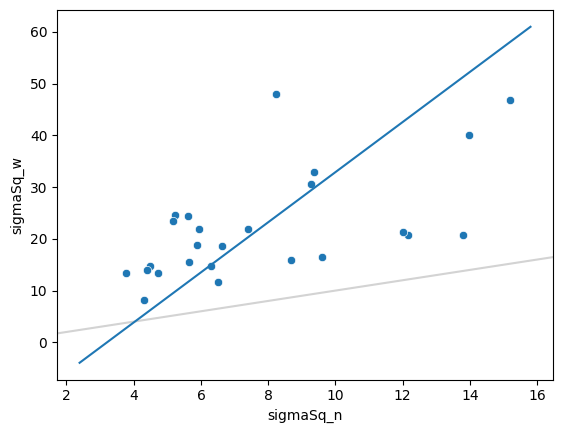

In [54]:
sns.scatterplot(data=results_nocognoise, x='sigmaSq_n', y='sigmaSq_w' )
#sns.relplot(data=results_nocognoise, x='sigma_n', y='sigma_w' )
plt.axline((3,3), slope=1, c='lightgrey', zorder=-1000)
odr_res = odr_1dregression(data=results_nocognoise, x='sigmaSq_n', y='sigmaSq_w')
odr_res.pprint()
plt.plot(plt.xlim(), odr_pred(odr_res, np.array(plt.xlim()), ) )

Subject $i$, prior $1$: $var_{i1} = \sigma_{i}^2 + w_1 \nu_i$  
Subject $i$, prior $2$: $var_{i2} = \sigma_{i}^2 + w_2 \nu_i$  
Thus $var_{i2} - var_{i1} = \nu_i (w_2 - w_1)$.  

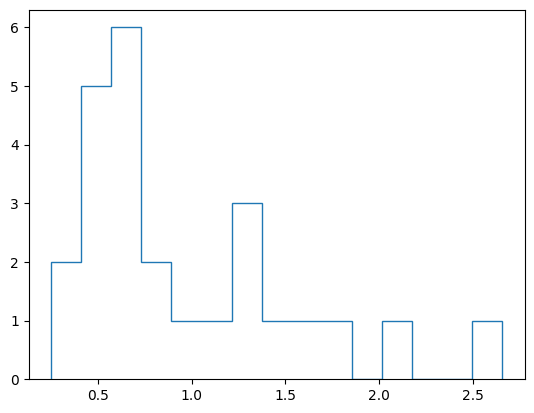

In [55]:
plt.hist( (results_nocognoise.sigmaSq_w - results_nocognoise.sigmaSq_n)/15,  bins=15, histtype='step' );

In [137]:
respooled_nocognoise

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 29007.610675334014
        x: [ 2.766e+00  4.665e+00]
      nit: 7
      jac: [ 0.000e+00  0.000e+00]
     nfev: 24
     njev: 8
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

(0.0, 4.810568188728809)

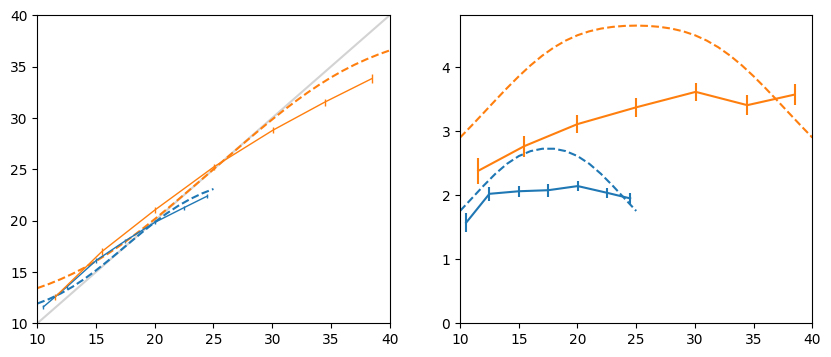

In [139]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    pxs = PRIORS_COND[cond]
    μxs = np.linspace(0,1,len(xs))
    σ = respooled_nocognoise.x[ic]
    pxhatx, avg_ests, stddev_ests = model_predictions(xs, pxs, μxs, ν=0, σ=σ, NUM_RS=100_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond], ls='--')
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

## No-motor-noise model

Model: $\sigma=0$, $\nu$ different in each condition.  
This can also be seen as a way to measure the overall noise separately in each condition.

Basically this is impossible to fit.  
If the cognitive noise is too small, the model subject is too precise and some responses that actually occur are just impossible under the model.  
But if the cognitive noise is too high, the model subject has a strong central tendency, and responses near the boundary are basically impossible.

In [69]:
def objf_nomotornoise(x):
    ν_n, ν_w = x
    r  = mLL_allsubjects_with_ν('narrow', ν=ν_n, σ=0)
    print(r)
    r += mLL_allsubjects_with_ν('wide',   ν=ν_w, σ=0)
    print(x, r)
    return r
res = optimize.minimize(objf_nomotornoise, x0=[.05, .05], bounds=[(1e-3,.13),]*2 )
print(res)
####### Per subject
def objf_nomotornoise_onesubj(x, sid):
    ν_n, ν_w = x
    r  = mLL_onesubject_with_ν(sid, 'narrow', ν=ν_n, σ=0)
    r += mLL_onesubject_with_ν(sid, 'wide', ν=ν_w, σ=0)
    #print(x, r)
    return r
results_nomotornoise = []
for sid in subject_ids:
    res = optimize.minimize(objf_nomotornoise_onesubj, x0=[.05, .05], args=(sid,), bounds=[(0.,.2),]*2)
    if not res.success:
        print('!', sid)
        print(res)
    results_nomotornoise.append([sid, res.x[0], res.x[1], res.fun])
results_nomotornoise = pd.DataFrame(results_nomotornoise, columns=['subject', 'nu_n', 'nu_w', 'mll'])
results_nomotornoise


34281.286182857955
[0.05 0.05] 66119.19412509914
34281.276385526675
[0.05000001 0.05      ] 66119.18432776787
34281.286182857955
[0.05       0.05000001] 66119.18587332517
15095.299166980043
[0.13 0.13] 35615.5670534949
15095.299528947293
[0.12999999 0.13      ] 35615.56741546215
15095.299166980043
[0.13       0.12999999] 35615.56737540518
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 35615.5670534949
        x: [ 1.300e-01  1.300e-01]
      nit: 1
      jac: [-3.620e+04 -3.219e+04]
     nfev: 6
     njev: 2
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


subject  nu_n  nu_w          mll
0       01  0.05  0.05  2702.012762
1       02  0.05  0.05  3460.705608
2       03  0.05  0.05  4154.147648
3       04  0.05  0.05  3211.291797
4       05  0.05  0.05  2538.968328
5       06  0.05  0.05  1755.493479
6       07  0.05  0.05  2083.112719
7       08  0.05  0.05  3541.324461
8       09  0.05  0.05  3224.685652
9       10  0.05  0.05  2401.708216
10      12  0.05  0.05  2562.433241
11      13  0.05  0.05  1584.010466
12      14  0.05  0.05  2070.056914
13      15  0.05  0.05  1791.494073
14      16  0.05  0.05  2381.021959
15      17  0.05  0.05  3321.813354
16      18  0.05  0.05  3198.857087
17      19  0.05  0.05  1868.159729
18      20  0.05  0.05  2358.097875
19      21  0.05  0.05  2163.363169
20      22  0.05  0.05  1892.999156
21      24  0.05  0.05  4537.579955
22      25  0.05  0.05  2360.798425
23      26  0.05  0.05  2360.962237
24      27  0.05  0.05  2594.095817

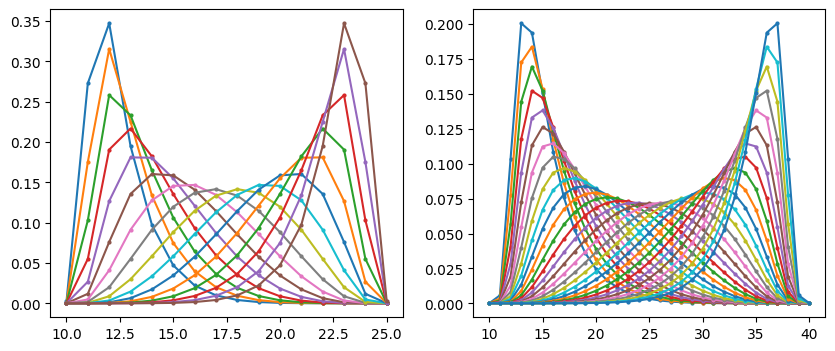

In [70]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    pxs = PRIORS_COND[cond]
    θcost = 1
    σ = 0
    μxs = np.linspace(0, 1, len(xs))
    ν = .2
    pxhatx = num.probs_xhats_given_x_with_μxs(xs, pxs, μxs, ν=ν, σ=σ, NUM_RS=100_000)
    axs[ic].plot(xs, pxhatx.T, 'o-', ms=2)

## Model with cognitive noise and motor noise 

### Unconstrained nu
The motor noise stays the same across conditions but not the cognitive noise.  
Will this fit??? [No]

In [72]:
def objf_unconstrained_ν(x):
    ν_n, ν_w, σ = x
    r  = mLL_allsubjects_with_ν('narrow', ν=ν_n, σ=σ)
    r += mLL_allsubjects_with_ν('wide', ν=ν_w, σ=σ)
    #print(x, r)
    return r
#res = optimize.minimize(objf_unconstrained_ν, x0=[.01, .01, 2], bounds=[(1e-4,2.), (1e-4,2.), (1e-2,None), ])
#print(res)
#res = optimize.minimize(objf_unconstrained_ν, x0=[.1, .1, 2], bounds=[(1e-4,2.), (1e-4,2.), (1e-2,None), ])
#print(res)
res, all_res = min_objf(objf_unconstrained_ν, x0s=itertools.product([.0001, .001, .01, .1], [.001, .01, .1], [2,3]), return_all_res=True, bounds=[(1e-5,2.), (1e-5,2.), (1e-2,None), ] )
print(res)
#plt.scatter( [r.x[0] for r in all_res], [r.x[1] for r in all_res], marker='x')


(0.0001, 0.001, 2) -> [1.00381360e-04 1.00036708e-03 3.89915062e+00] 29568.983399893455
(0.0001, 0.001, 3) -> [9.99542015e-05 9.99684054e-04 3.89915107e+00] 29568.983399893455
(0.0001, 0.01, 2) -> [9.9718261e-05 1.0000000e-05 3.8991510e+00] 29568.98339989344
(0.0001, 0.01, 3) -> [1.00000000e-04 1.30390036e-01 2.79581597e+00] 29085.71602331515
(0.0001, 0.1, 2) -> [9.99726178e-05 1.30390046e-01 2.79581583e+00] 29085.716023315043
(0.0001, 0.1, 3) -> [9.97640687e-05 1.30390104e-01 2.79581564e+00] 29085.716023314955
(0.001, 0.001, 2) -> [1.00000000e-03 1.00000000e-03 3.89915066e+00] 29568.983399893445
(0.001, 0.001, 3) -> [1.00000000e-03 1.00000000e-03 3.89915123e+00] 29568.983399893506
(0.001, 0.01, 2) -> [1.00000000e-03 1.00000000e-05 3.89915071e+00] 29568.98339989344
(0.001, 0.01, 3) -> [9.99957696e-04 1.30390099e-01 2.79581581e+00] 29085.71602331505
(0.001, 0.1, 2) -> [1.00000000e-03 1.30389966e-01 2.79581969e+00] 29085.716023323606
(0.001, 0.1, 3) -> [1.00023594e-03 1.30390097e-01 2.79

In [73]:
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 29085.716023314955
        x: [ 9.976e-05  1.304e-01  2.796e+00]
      nit: 11
      jac: [ 0.000e+00  8.731e-03  3.638e-04]
     nfev: 56
     njev: 14
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

I don't believe in this fit

### nu_w = sqrt(2) nu_n

In [140]:
def objf_basemodel(x):
    ν_n, σ = x
    ν_w = np.sqrt(2)*ν_n
    r  = mLL_allsubjects_with_ν('narrow', ν=ν_n, σ=σ)
    r += mLL_allsubjects_with_ν('wide', ν=ν_w, σ=σ)
    #print(x, r)
    return r
#res = optimize.minimize(objf_unconstrained_ν, x0=[.01, .01, 2], bounds=[(1e-4,2.), (1e-4,2.), (1e-2,None), ])
#print(res)
#res = optimize.minimize(objf_unconstrained_ν, x0=[.1, .1, 2], bounds=[(1e-4,2.), (1e-4,2.), (1e-2,None), ])
#print(res)
respooled_basemodel, all_res = min_objf(objf_basemodel, x0s=itertools.product([.001, .01, .1, .2], [2,3]), bounds=[(1e-5,2.), (1e-2,None), ], return_all_res=True )
print(respooled_basemodel)
#plt.scatter( [r.x[0] for r in all_res], [r.x[1] for r in all_res], marker='x')
#[r.fun for r in all_res]

####### Per subject
def objf_basemodel_onesubj(x, sid):
    ν_n, σ = x
    ν_w = np.sqrt(2)*ν_n
    r  = mLL_onesubject_with_ν(sid, 'narrow', ν=ν_n, σ=σ)
    r += mLL_onesubject_with_ν(sid, 'wide', ν=ν_w, σ=σ)
    #print(x, r)
    return r
results_basemodel = []
for sid in subject_ids:
    #print(sid)
    #res = optimize.minimize(objf_basemodel_onesubj, x0=[.01, 2.5], args=(sid,), bounds=[(0.,None),]*2)
    res, all_res = min_objf(objf_basemodel_onesubj, x0s=itertools.product([.01, .1, .2], [2, 3]), args=(sid,), bounds=[(1e-5,None),]*2, return_all_res=True, v=0)
    if not res.success:
        print('!', sid)
        print(res)
    print(sid, res.x, res.fun, np.std([r.x for r in all_res], axis=0) )
    results_basemodel.append([sid, res.x[0], res.x[1], res.fun])
results_basemodel = pd.DataFrame(results_basemodel, columns=['subject', 'nu_n', 'sigma', 'mll'])
print('-LL =', results_basemodel['mll'].sum() )
results_basemodel

(0.001, 2) -> [9.99632920e-04 3.89915066e+00] 29568.98339989345
(0.001, 3) -> [1.00000000e-03 3.89915134e+00] 29568.98339989356
(0.01, 2) -> [1.03622548e-05 3.89915087e+00] 29568.983399893426
(0.01, 3) -> [0.09441979 2.49161647] 29149.297884949705
(0.1, 2) -> [0.09441981 2.49161701] 29149.29788494866
(0.1, 3) -> [0.09441989 2.49161602] 29149.297884946864
(0.2, 2) -> [0.0944199  2.49162125] 29149.297884962794
(0.2, 3) -> [0.09442022 2.4916012 ] 29149.29788501155
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 29149.297884946864
        x: [ 9.442e-02  2.492e+00]
      nit: 6
      jac: [-5.821e-03  3.638e-04]
     nfev: 24
     njev: 8
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
01 [0.08415518 2.69878327] 1141.3894244003995 [1.39612311e-06 2.21651260e-05]
02 [0.07776944 3.44531543] 1224.3461164711678 [2.95937955e-07 1.03432321e-05]
03 [0.14243525 3.14983197] 1250.0030401591446 [2.46601275e-07 1.53408080e-06]
04 [0.06637821 3

/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


subject      nu_n     sigma          mll
0       01  0.084155  2.698783  1141.389424
1       02  0.077769  3.445315  1224.346116
2       03  0.142435  3.149832  1250.003040
3       04  0.066378  3.444767  1189.632869
4       05  0.085350  2.527798  1183.369507
5       06  0.071934  1.733176  1076.487134
6       07  0.052055  2.501020  1114.381920
7       08  0.150747  2.488180  1197.349955
8       09  0.135788  2.321492  1218.375290
9       10  0.100026  2.095143  1147.952888
10      12  0.066402  2.804031  1148.783517
11      13  0.051234  1.911371  1035.960234
12      14  0.068089  2.334781  1095.198506
13      15  0.080283  1.829701  1035.375210
14      16  0.108991  1.749695  1134.159787
15      17  0.143869  2.467974  1220.517315
16      18  0.073979  3.342186  1196.861135
17      19  0.068918  2.011437  1084.243356
18      20  0.139749  1.394414  1129.496155
19      21  0.064982  2.463541  1112.690204
20      22  0.068669  2.002994  1094.616923
21      24  0.201810  2.685539  1251.669862
22      25  0.068143  2.624705  1147.239630
23      26  0.086065  2.292265  1141.610351
24      27  0.110832  2.252862  1157.005542

(16, 16)
(16,)
(31, 31)
(31,)


(0.0, 4.785401130412855)

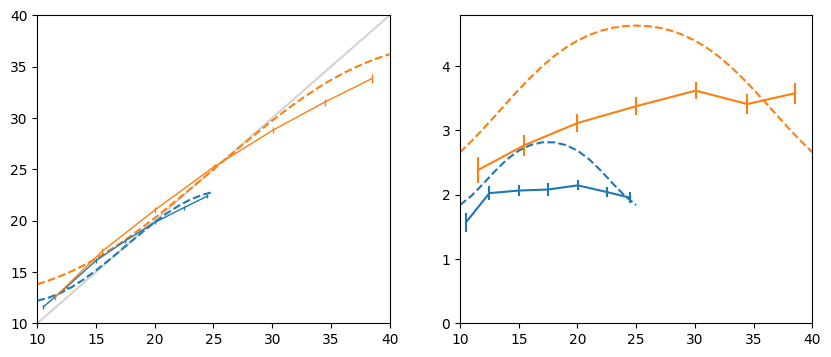

In [564]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    pxs = PRIORS_COND[cond]
    μxs = np.linspace(0,1,len(xs))
    σ = respooled_basemodel.x[1]
    ν = respooled_basemodel.x[0]*(np.sqrt(2) if cond=='wide' else 1)
    pxhatx, avg_ests, stddev_ests = model_predictions(xs, pxs, μxs, ν=ν, σ=σ, NUM_RS=100_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond], ls='--')
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

## Models with subjective prior + efficient coding

In [162]:
def mLL_effcoding_subjective_prior(dat, sxs, spxs, θcost, σ, correct_w, NUM_RS=10_000):
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(spxs, θcost)
    return mLL(dat, sxs, spxs, μxs, ν, σ, correct_w, NUM_RS=NUM_RS)

### Correct-support prior 

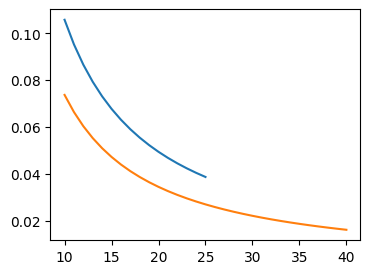

In [753]:
ZIPF_COND = {}; plt.figure(figsize=(4,3))
for cond,xs in XS_COND.items():
    zps = stats.zipf(a=1.1).pmf(xs)
    zps /= zps.sum()
    plt.plot(xs, zps, c=COLORS_COND[cond] )
    zps.flags.writeable = False
    ZIPF_COND[cond] = zps

In [756]:
stats.zipf(a=1.1).pmf(1)

0.09447823411029742

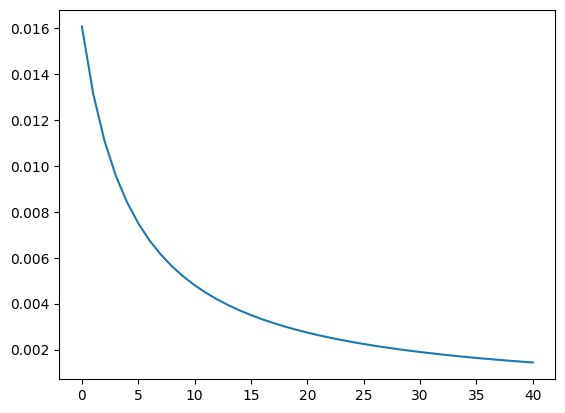

In [757]:
plt.plot( stats.zipf(a=1.1).pmf(np.arange(5,46)) )

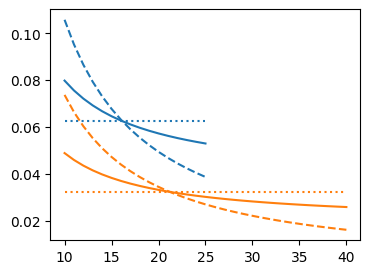

In [758]:
def get_interp_prior(cond, alpha):
    return alpha*PRIORS_COND[cond] + (1-alpha)*ZIPF_COND[cond]
plt.figure(figsize=(4,3))
for cond,xs in XS_COND.items():
    plt.plot(xs, get_interp_prior(cond, 0),  c=COLORS_COND[cond], ls='--' )
    plt.plot(xs, get_interp_prior(cond, .6), c=COLORS_COND[cond] )
    plt.plot(xs, get_interp_prior(cond, 1),  c=COLORS_COND[cond], ls=':' )

In [759]:
def mLL_effcoding_interp_prior(dat, cond, alpha, θcost, σ, NUM_RS=10_000):
    xs = XS_COND[cond]
    zpxs = get_interp_prior(cond, alpha)
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(zpxs, θcost)
    correct_w = WIDTHS_COND[cond]
    return mLL(dat, xs, zpxs, μxs, ν, σ, correct_w, NUM_RS=NUM_RS)

In [760]:
@cache
def mLL_allsubjects_interp_prior(cond, alpha, θcost, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)]
    return mLL_effcoding_interp_prior(dat, cond, alpha, θcost, σ, NUM_RS=NUM_RS)
@cache
def mLL_onesubject_interp_prior(sid, cond, alpha, θcost, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)].loc[sid]
    return mLL_effcoding_interp_prior(dat, cond, alpha, θcost, σ, NUM_RS=NUM_RS)

In [761]:
mLL_allsubjects_interp_prior('narrow', .6, .1, 3)

13305.716775003015

In [854]:
def objf_interpmodel(x):
    alpha, θcost, σ = x
    r  = mLL_allsubjects_interp_prior('narrow', alpha, θcost, σ)
    r += mLL_allsubjects_interp_prior('wide', alpha, θcost, σ)
    #print(x, r)
    return r
res, all_res = min_objf(objf_interpmodel, x0s=itertools.product([.2, .5, .8], [.1,1], [3,]), bounds=[(0,1), (0,None), (0,None) ], return_all_res=True )
print(res)

(0.2, 0.1, 3) -> [0.         0.17992332 1.94230634] 29128.873269428674
(0.2, 1, 3) -> [0.         0.1799115  1.94228696] 29128.87326768849
(0.5, 0.1, 3) -> [0.         0.17991156 1.94228805] 29128.87326768966
(0.5, 1, 3) -> [0.         0.17991081 1.9422885 ] 29128.87326768844
(0.8, 0.1, 3) -> [0.         0.17991059 1.94228846] 29128.87326768969
(0.8, 1, 3) -> [0.         0.17991174 1.94228598] 29128.87326768975
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 29128.87326768844
        x: [ 0.000e+00  1.799e-01  1.942e+00]
      nit: 10
      jac: [ 2.058e+02 -2.910e-03  0.000e+00]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


0.17545713867240526
(16, 16)
(16,)
0.12327668132115507
(31, 31)
(31,)


(0.0, 4.395557843528914)

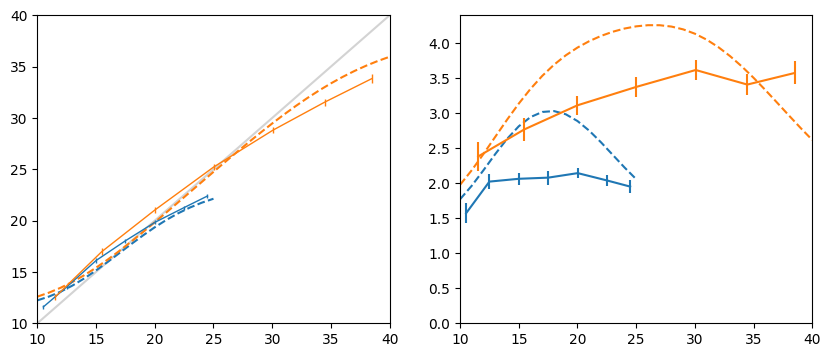

In [855]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    alpha, θcost, σ = res.x
    zpxs = get_interp_prior(cond, alpha)
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(zpxs, θcost)
    print(ν)
    pxhatx, avg_ests, stddev_ests = model_predictions(xs, zpxs, μxs, ν=ν, σ=σ, NUM_RS=100_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    #axs[0].plot(xs, avg_ests-xs, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond], ls='--')
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            #axs[0].errorbar(xx, np.nanmean(avgzz, axis=0)-xx, stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

In [763]:
def objf_interpmodel2(x):
    alpha_n, alpha_w, θcost, σ = x
    r  = mLL_allsubjects_interp_prior('narrow', alpha_n, θcost, σ)
    r += mLL_allsubjects_interp_prior('wide', alpha_w, θcost, σ)
    #print(x, r)
    return r
res = min_objf(objf_interpmodel2, x0s=itertools.product([.2, .5, .8], [.2, .5, .8], [.1,1], [3,]), bounds=[(0,1), (0,1), (0,None), (0,None) ] )
print(res)

(0.2, 0.2, 0.1, 3) -> [0.72659572 0.         0.19490648 1.91012685] 29102.289499158185
(0.2, 0.2, 1, 3) -> [0.72659989 0.         0.19490762 1.91012223] 29102.28949914216
(0.2, 0.5, 0.1, 3) -> [0.72671726 0.         0.19490445 1.91012435] 29102.28949954659
(0.2, 0.5, 1, 3) -> [0.726626   0.         0.19490663 1.91012625] 29102.289499087994
(0.2, 0.8, 0.1, 3) -> [0.72659002 0.         0.19490802 1.91011855] 29102.289499188268
(0.2, 0.8, 1, 3) -> [0.72662815 0.         0.19491008 1.91012434] 29102.28949913899
(0.5, 0.2, 0.1, 3) -> [0.72674462 0.         0.19490715 1.91014626] 29102.289499835955
(0.5, 0.2, 1, 3) -> [0.72658955 0.         0.19490617 1.9101313 ] 29102.289499194747
(0.5, 0.5, 0.1, 3) -> [0.72667918 0.         0.19490747 1.91013034] 29102.289499202634
(0.5, 0.5, 1, 3) -> [0.72662537 0.         0.19490164 1.91016509] 29102.289499504426
(0.5, 0.8, 0.1, 3) -> [0.72660211 0.         0.19490593 1.9101275 ] 29102.289499140694
(0.5, 0.8, 1, 3) -> [0.72658446 0.         0.19490587 1.

(16, 16)
(16,)
(31, 31)
(31,)


(0.0, 4.439270644256122)

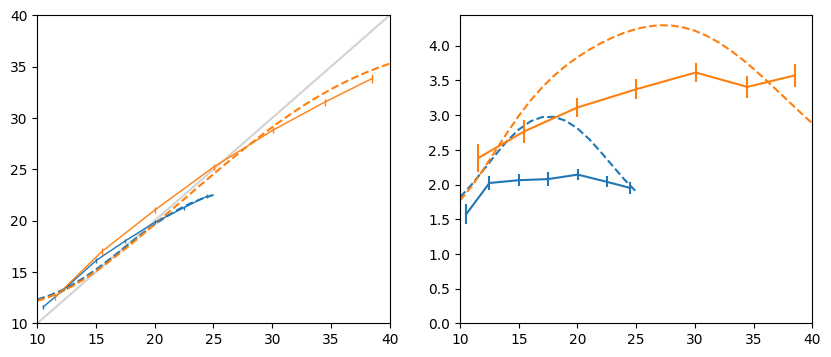

In [734]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    alpha_n, alpha_w, θcost, σ = res.x
    zpxs = get_interp_prior(cond, {'narrow':alpha_n, 'wide':alpha_w}[cond])
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(zpxs, θcost)
    pxhatx, avg_ests, stddev_ests = model_predictions(xs, zpxs, μxs, ν=ν, σ=σ, NUM_RS=100_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    #axs[0].plot(xs, avg_ests-xs, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond], ls='--')
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            #axs[0].errorbar(xx, np.nanmean(avgzz, axis=0)-xx, stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

### Wider prior

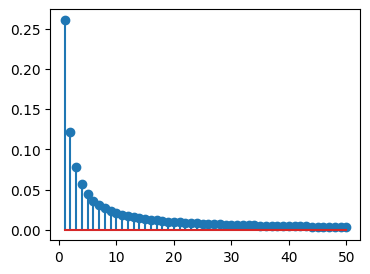

In [775]:
ZIPF_XS = np.arange(1,51)
ZIPF_PXS = stats.zipf(a=1.1).pmf(ZIPF_XS)
ZIPF_PXS /= ZIPF_PXS.sum()
plt.figure(figsize=(4,3)); plt.stem(ZIPF_XS, ZIPF_PXS,)
ZIPF_XS.flags.writeable = False
ZIPF_PXS.flags.writeable = False

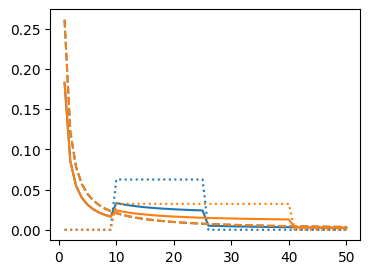

In [776]:
def get_interp_wideZipfprior(cond, alpha):
    r = (1-alpha)*ZIPF_PXS
    r[ np.isin(ZIPF_XS, XS_COND[cond]) ] += alpha*PRIORS_COND[cond]
    return r
plt.figure(figsize=(4,3))
for cond in CONDITIONS:
    plt.plot(ZIPF_XS, get_interp_wideZipfprior(cond, 0),  c=COLORS_COND[cond], ls='--' )
    plt.plot(ZIPF_XS, get_interp_wideZipfprior(cond, .3), c=COLORS_COND[cond] )
    plt.plot(ZIPF_XS, get_interp_wideZipfprior(cond, 1),  c=COLORS_COND[cond], ls=':' )

In [777]:
def mLL_effcoding_interp_wideZipf(dat, cond, alpha, θcost, σ, NUM_RS=10_000):
    zpxs = get_interp_wideZipfprior(cond, alpha)
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(zpxs, θcost)
    correct_w = WIDTHS_COND[cond]
    return mLL(dat, ZIPF_XS, zpxs, μxs, ν, σ, correct_w, NUM_RS=NUM_RS)

In [778]:
@cache
def mLL_allsubjects_interp_wideZipf(cond, alpha, θcost, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)]
    return mLL_effcoding_interp_wideZipf(dat, cond, alpha, θcost, σ, NUM_RS=NUM_RS)
@cache
def mLL_onesubject_interp_wideZipf(sid, cond, alpha, θcost, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)].loc[sid]
    return mLL_effcoding_interp_wideZipf(dat, cond, alpha, θcost, σ, NUM_RS=NUM_RS)

In [779]:
mLL_allsubjects_interp_wideZipf('narrow', .7, .05, 3)

13202.227584500713

In [781]:
def objf_interpwideZipfmodel(x):
    alpha, θcost, σ = x
    r  = mLL_allsubjects_interp_wideZipf('narrow', alpha, θcost, σ)
    r += mLL_allsubjects_interp_wideZipf('wide', alpha, θcost, σ)
    #print(x, r)
    return r
res, all_res = min_objf(objf_interpwideZipfmodel, x0s=itertools.product([.2, .5, .8], [.1,1], [3,]), bounds=[(0,1), (0,None), (0,None) ], return_all_res=True )
print(res)

(0.2, 0.1, 3) -> [0.5605484  0.11617839 1.70880105] 29083.066565833993
(0.2, 1, 3) -> [0.48732149 0.94370183 1.18960999] 30570.76962514701
(0.5, 0.1, 3) -> [0.89460293 0.28224381 1.11044792] 28925.168856323893
(0.5, 1, 3) -> [0.65617376 0.68765248 2.06295743] 29829.21714337804
(0.8, 0.1, 3) -> [0.86121972 0.12380291 1.971203  ] 29064.11643528731
(0.8, 1, 3) -> [0.86311944 0.6844028  2.0532084 ] 29435.72767335453
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 28925.168856323893
        x: [ 8.946e-01  2.822e-01  1.110e+00]
      nit: 12
      jac: [-4.366e-03  1.237e-02  0.000e+00]
     nfev: 68
     njev: 17
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


(16, 16)
(16,)
(31, 31)
(31,)


(0.0, 4.528865728619993)

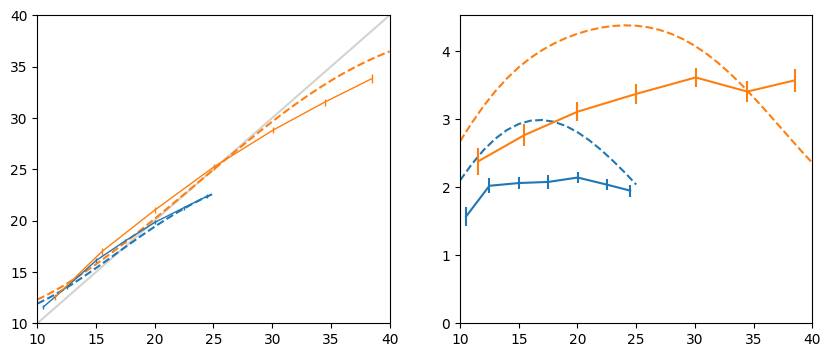

In [782]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    alpha, θcost, σ = res.x
    zpxs = get_interp_wideZipfprior(cond, alpha)
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(zpxs, θcost)
    pxhatx, avg_ests, stddev_ests = model_predictions(ZIPF_XS, zpxs, μxs, ν=ν, σ=σ, correct_xs=xs, NUM_RS=100_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond], ls='--')
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

(16, 16)
(16,)
(31, 31)
(31,)


(0.0, 3.869745007543534)

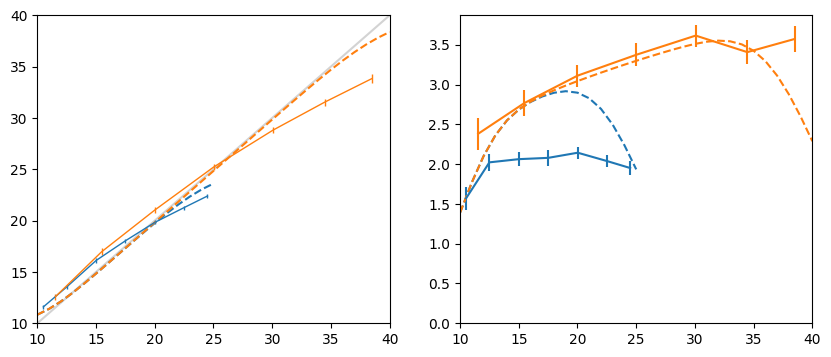

In [785]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    zpxs = get_interp_wideZipfprior(cond, alpha=0)
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(zpxs, θcost=.015)
    #print(μxs)
    pxhatx, avg_ests, stddev_ests = model_predictions(ZIPF_XS, zpxs, μxs, ν=ν, σ=σ*0, correct_xs=xs, NUM_RS=100_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond], ls='--')
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

In [787]:
def objf_interpwideZipfmodel_2(x):
    alpha_n, alpha_w, θcost, σ = x
    r  = mLL_allsubjects_interp_wideZipf('narrow', alpha_n, θcost, σ)
    r += mLL_allsubjects_interp_wideZipf('wide', alpha_w, θcost, σ)
    #print(x, r)
    return r
res = min_objf(objf_interpwideZipfmodel_2, x0s=itertools.product([.2, .5, .8], [.2, .5, .8], [.1,1], [3,]), bounds=[(0,1),(0,1), (0,None), (0,None) ] )
print(res)

(0.2, 0.2, 0.1, 3) -> [0.56274756 0.53723341 0.09231843 1.68476429] 29079.235204128763
(0.2, 0.2, 1, 3) -> [0.44837323 0.40300128 0.89669969 1.58118574] 30719.71380780894
(0.2, 0.5, 0.1, 3) -> [0.74705382 0.78704374 0.16152229 1.09486928] 29023.504641346328
(0.2, 0.5, 1, 3) -> [0.74958198 0.49550278 0.54421743 0.        ] 29416.678906069345
(0.2, 0.8, 0.1, 3) -> [0.44939187 0.55060813 0.06882602 2.06478047] 29202.088273987196
(0.2, 0.8, 1, 3) -> [0.44479602 0.86119901 0.69400497 2.08201491] 30079.57082633204
(0.5, 0.2, 0.1, 3) -> [0.90712548 0.45058859 0.16978724 0.97308704] 28841.77700830341
(0.5, 0.2, 1, 3) -> [0.65151515 0.44242424 0.6969697  2.09090909] 30062.25444160436
(0.5, 0.5, 0.1, 3) -> [0.74807824 0.71453908 0.13977983 1.6131962 ] 29005.64409943795
(0.5, 0.5, 1, 3) -> [0.65430335 0.65430335 0.6913933  2.0741799 ] 29840.435248007896
(0.5, 0.8, 0.1, 3) -> [0.90712115 0.45058135 0.16978539 0.97308552] 28841.77700815323
(0.5, 0.8, 1, 3) -> [0.65586992 0.86234797 0.68826016 2.064

(16, 16)
(16,)
(31, 31)
(31,)


(0.0, 4.729834193023197)

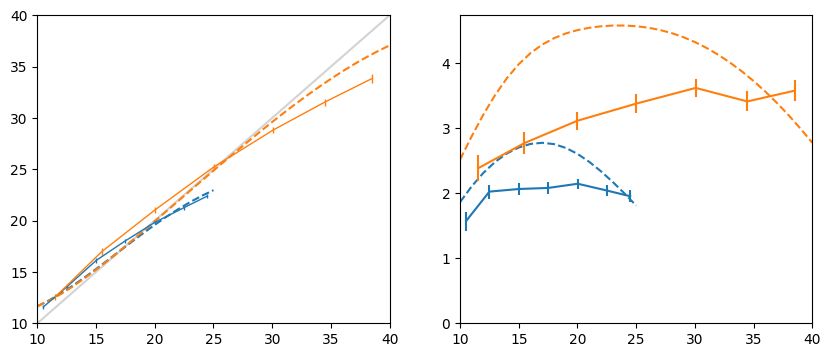

In [790]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    alpha_n, alpha_w, θcost, σ = res.x
    zpxs = get_interp_wideZipfprior(cond, {'narrow':alpha_n, 'wide':alpha_w}[cond])
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(zpxs, θcost)
    pxhatx, avg_ests, stddev_ests = model_predictions(ZIPF_XS, zpxs, μxs, ν=ν, σ=σ, correct_xs=xs, NUM_RS=100_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond], ls='--')
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

## Constant-variance truncated motor noise 

In [399]:
def var_truncated_normal(mu, sigma, a, b):
    sigma = np.asarray(sigma, dtype=float)
    out = np.zeros_like(sigma, dtype=float)
    mask = sigma > 0
    if np.any(mask):
        alpha = (a-mu)/sigma[mask]
        beta = (b-mu)/sigma[mask]
        Z = num.std_normal_cdf_difference(alpha, beta)
        #print(np.count_nonzero(Z==0), mu, sigma[mask][Z==0], alpha[Z==0], beta[Z==0])
        out[mask] = 1 - (beta*num.std_normal_pdf(beta)-alpha*num.std_normal_pdf(alpha))/Z - (num.std_normal_pdf_difference(alpha, beta)/Z)**2
        out[mask] *= sigma[mask]**2
    return out

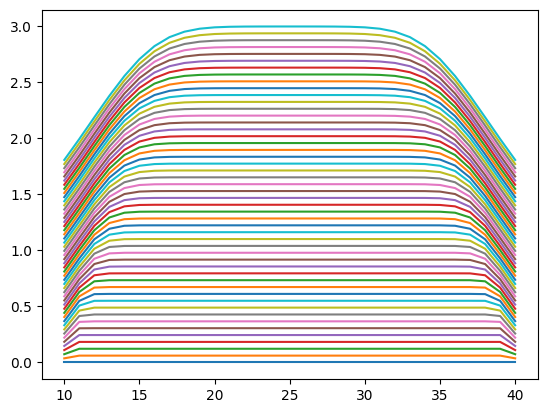

In [400]:
xs = XS_COND['wide']
for sigma in np.linspace(0, 3):
    plt.plot(xs, [var_truncated_normal(x, sigma, xs[0], xs[-1])**(1/2) for x in xs])

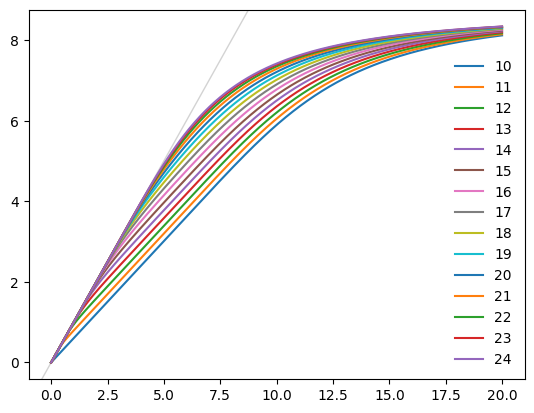

In [401]:
xs = XS_COND['wide']
sigmas = np.linspace(0, 20, 1000)
for x in xs[:15]:
    plt.plot(sigmas, var_truncated_normal(x, sigmas, xs[0], xs[-1])**(1/2), label=x)
plt.legend()
plt.axline((1,1), slope=1, zorder=-1000, c='lightgrey', lw=1)

In [464]:
from scipy import interpolate

In [493]:
# function which, given sd, returns the parameter sigma of a truncated normal whose standard deviation is sd
def sigma_from_sd(sd, mu, a, b):
    # sd <= sigma
    sigmas = np.linspace(sd, 20, 1000)
    sds = var_truncated_normal(mu=mu, sigma=sigmas, a=a, b=b)**(1/2)
    return np.interp(sd, sds, sigmas)

In [498]:
var_truncated_normal(mu=12, sigma=2, a=10, b=40)**(1/2), var_truncated_normal(mu=19, sigma=2, a=10, b=40)**(1/2)

(1.5870554946524151, 1.9999280713717207)

In [500]:
sigma_from_sd(1.5870554946524151, 12, 10, 40), sigma_from_sd(1.9999280713717207, 19, 10, 40)

(2.000001457760181, 2.000000004229516)

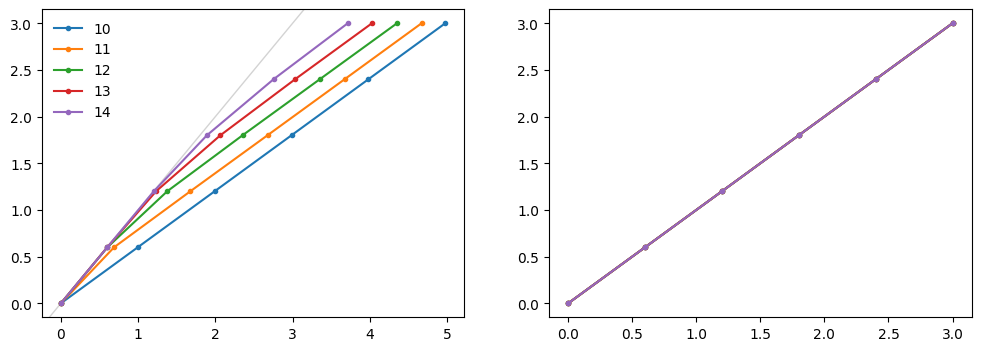

In [501]:
xs = XS_COND['wide']
a = xs[0]; b = xs[-1]
sds = np.linspace(0, 3, 6)
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
for x in xs[:5]:
    sigmas = np.array([ sigma_from_sd(sd, mu=x, a=a, b=b) for sd in sds ])
    axs[0].plot(sigmas, var_truncated_normal(x, sigmas, a, b)**(1/2), '.-', label=x)
    axs[1].plot(sds,    var_truncated_normal(x, sigmas, a, b)**(1/2), '.-', label=x)
axs[0].legend()
axs[0].axline((1,1), slope=1, zorder=-1000, c='lightgrey', lw=1)


In [503]:
import warnings

In [527]:
def probs_xhats_given_xB_cstvar(xB, lo, w, sd):
    '''Given a Bayesian estimate xB, and some constant-variance truncated-Gaussian noise with stndard deviation sd,
    this returns the probability of each possible discrete (integer) response xhat between lo and lo+w.'''
    hi = lo + w
    if sd == 0:
        ps = np.zeros(int(w)+1)
        ps[int(np.round(xB)-lo)] = 1.
        return ps
    xhats = num.discrete_xs(lo, w)
    sigma = sigma_from_sd(sd=sd, mu=xB, a=lo, b=hi)
    ps = num.trunc_normal_Pab(a=xhats-.5, b=xhats+.5, mu=xB, sigma=sigma, lo=lo-.5, hi=hi+.5)
    #assert np.allclose(ps.sum(axis=-1), 1)
    if not np.allclose(ps.sum(axis=-1), 1):
        warnings.warn('p xhats given xB does not sum to 1.')
    return ps

def probs_xhats_given_xBs_cstvar_array(xBs, lo, w, sd):
    return np.array( [ probs_xhats_given_xB_cstvar(xB, lo, w, sd) for xB in xBs ] )

In [528]:
probs_xhats_given_xB_cstvar(13, 10, 30, 2)

array([8.18558129e-02, 1.26440601e-01, 1.64129004e-01, 1.79040393e-01, 1.64129004e-01, 1.26440601e-01, 8.18558129e-02, 4.45313411e-02,
       2.03574598e-02, 7.82002587e-03, 2.52407331e-03, 6.84517676e-04, 1.55967351e-04, 2.98555019e-05, 4.80098378e-06, 6.48519933e-07,
       7.35824921e-08, 7.01218982e-09, 5.61216126e-10, 3.77201005e-11, 2.12887685e-12, 1.00886275e-13, 4.01408527e-15, 1.34086056e-16,
       3.76004711e-18, 8.85087976e-20, 1.74877816e-21, 2.90008452e-23, 4.03633978e-25, 4.71455139e-27, 4.62108663e-29])

In [530]:
probs_xhats_given_xBs_cstvar_array(np.array([13., 14]), 10, 30, 2).sum(axis=1)

array([1., 1.])

In [531]:
def probs_xhats_given_x_with_μxs_cstvar(sxs, spxs, μxs, ν, sd, lo=None, w=None, NUM_RS=10_000, NUM_STDS=4):
    assert sxs.shape == spxs.shape
    assert sxs.shape == μxs.shape
    lo = sxs[0] if lo is None else lo
    w  = (sxs[-1]-sxs[0]) if w is None else w
    if ν==0:
        p_xhats_given_xs = probs_xhats_given_xBs_cstvar_array(sxs, lo=lo, w=w, sd=sd)
    else:
        rs = np.linspace(-NUM_STDS*ν, 1+NUM_STDS*ν, num=NUM_RS)
        p_rs_μxs = num.probs_rs_given_μxs(rs, μxs, ν) # shape = (size of sxs, NUM_RS)
        # If the noise is small some rs will have probability zero. To avoid problems further down, we filter them out.
        ind_impossible_rs = p_rs_μxs.max(axis=0) == 0
        p_possible_rs_μxs = p_rs_μxs[:, ~ind_impossible_rs]
        xBs = num.xBs_using_p_rs_μxs(sxs, spxs, p_possible_rs_μxs)
        #p_rs_μxs is p(r|x)   ### ===> it is p(xB(r) | x)
        p_xhats_given_xBs = probs_xhats_given_xBs_cstvar_array(xBs, lo=lo, w=w, sd=sd) # shape = (NUM_RS_filtered, size of xhats)
        p_xhats_given_xs = np.dot(p_possible_rs_μxs, p_xhats_given_xBs) # p(xhat | x)
    #assert np.allclose( p_xhats_given_xs.sum(axis=1), 1 )
    if not np.allclose( p_xhats_given_xs.sum(axis=1), 1 ):
        warnings.warn('p_xhats_given_xs does not sum to 1.')
    return p_xhats_given_xs # p(xhat | x), shape = (size of sxs, size of xs). And p_xhats_given_xs[i] = probs of xhats given x=x_i

In [532]:
del σ

In [533]:
def mLL_cstvar(dat, sxs, spxs, μxs, ν, sd, w, lo=10, NUM_RS=10_000):
    #print( ν, σ, w )
    pxhatx = probs_xhats_given_x_with_μxs_cstvar(sxs, spxs, μxs, ν=ν, sd=sd, lo=lo, w=w, NUM_RS=NUM_RS)
    #print(pxhatx)
    pxhatx_onsupport = pxhatx[(sxs>=lo) & (sxs<=(lo+w))]
    logpxhatx = np.where(pxhatx_onsupport>0, pxhatx_onsupport, -np.inf)
    np.log(logpxhatx, out=logpxhatx, where=logpxhatx>0)
    #print(logpxhatx)
    return -logpxhatx[dat.n.astype(int)-lo,dat.response.astype(int)-lo].sum()

In [534]:
def mLL_with_ν_cstvar(dat, cond, ν, sd, NUM_RS=10_000): # straightfoward with ν
    xs = XS_COND[cond]
    pxs = PRIORS_COND[cond]
    correct_w = WIDTHS_COND[cond]
    dat_ = dat[dat.range==cond]
    μxs = np.linspace(0, 1, len(xs))
    return mLL_cstvar(dat_, xs, pxs, μxs, ν, sd, w=correct_w, lo=10, NUM_RS=NUM_RS)

In [535]:
@cache
def mLL_allsubjects_with_ν_cstvar(cond, ν, sd, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)]
    return mLL_with_ν_cstvar(dat, cond, ν, sd, NUM_RS=NUM_RS) 

In [536]:
mLL_allsubjects_with_ν_cstvar('narrow', .1, 2)

12970.5274783036

In [544]:
def objf_basemodel_cstvar(x):
    ν_n, sd = x
    ν_w = np.sqrt(2)*ν_n
    r  = mLL_allsubjects_with_ν_cstvar('narrow', ν=ν_n, sd=sd)
    r += mLL_allsubjects_with_ν_cstvar('wide', ν=ν_w, sd=sd)
    #print(x, r)
    return r

res, all_res = min_objf(objf_basemodel_cstvar, x0s=itertools.product([.001, .01, .1, .2], [2,3]), bounds=[(1e-5,2.), (1e-2,None), ], return_all_res=True )
print(res)

(0.001, 2) -> [1.00003390e-03 3.10223133e+00] 29851.915497708156
(0.001, 3) -> [1.00002760e-03 3.10221349e+00] 29851.91549820054
(0.01, 2) -> [0.09829551 2.10613096] 29147.594612343997
(0.01, 3) -> [0.09829533 2.10613214] 29147.5946123367
(0.1, 2) -> [0.09829533 2.10613183] 29147.594612336623
(0.1, 3) -> [0.09829532 2.10613225] 29147.59461233658
(0.2, 2) -> [0.09829536 2.10613132] 29147.594612337103


KeyboardInterrupt: 

In [540]:
def model_predictions_cstvar(sxs, spxs, μxs, ν, sd, correct_xs=None, NUM_RS=100_000):
    if correct_xs is None: correct_xs = sxs
    pxhatx = probs_xhats_given_x_with_μxs_cstvar(sxs, spxs, μxs, ν=ν, sd=sd, lo=correct_xs[0], w=correct_xs[-1]-correct_xs[0], NUM_RS=NUM_RS)
    pxhatx = pxhatx[ np.isin(sxs, correct_xs) ]
    #print(pxhatx.shape)
    avg_ests = (pxhatx*correct_xs).sum(axis=1)
    #print(avg_ests.shape)
    stddev_ests = np.sqrt( (pxhatx*(xs-avg_ests[...,np.newaxis])**2).sum(axis=1) )
    return pxhatx, avg_ests, stddev_ests

[0.         0.05143643 0.09326762 0.13005648 0.16353788 0.19461204 0.22382262 0.25152974 0.27798748 0.30338351 0.32786136 0.35153396
 0.37449208 0.39681012 0.41855    0.43976391 0.46049641 0.48078588 0.50066569 0.5201651  0.53930989 0.558123   0.57662489 0.59483392
 0.61276667 0.63043815 0.64786201 0.66505071 0.68201567 0.69876737 0.71531548 0.73166893 0.74783599 0.76382434 0.77964113 0.79529302
 0.81078626 0.82612667 0.84131973 0.85637058 0.87128405 0.88606472 0.90071688 0.91524459 0.92965173 0.94394192 0.95811863 0.97218516
 0.98614462 1.        ]


/var/folders/jq/_79_qpxx3vd0thkqqmw37l1c0000gn/T/ipykernel_64269/1076561706.py:10: RuntimeWarning: invalid value encountered in divide
  out[mask] = 1 - (beta*num.std_normal_pdf(beta)-alpha*num.std_normal_pdf(alpha))/Z - (num.std_normal_pdf_difference(alpha, beta)/Z)**2
/var/folders/jq/_79_qpxx3vd0thkqqmw37l1c0000gn/T/ipykernel_64269/1076561706.py:10: RuntimeWarning: divide by zero encountered in divide
  out[mask] = 1 - (beta*num.std_normal_pdf(beta)-alpha*num.std_normal_pdf(alpha))/Z - (num.std_normal_pdf_difference(alpha, beta)/Z)**2
/var/folders/jq/_79_qpxx3vd0thkqqmw37l1c0000gn/T/ipykernel_64269/1788881380.py:5: RuntimeWarning: invalid value encountered in sqrt
  sds = var_truncated_normal(mu=mu, sigma=sigmas, a=a, b=b)**(1/2)
/var/folders/jq/_79_qpxx3vd0thkqqmw37l1c0000gn/T/ipykernel_64269/1076561706.py:10: RuntimeWarning: invalid value encountered in subtract
  out[mask] = 1 - (beta*num.std_normal_pdf(beta)-alpha*num.std_normal_pdf(alpha))/Z - (num.std_normal_pdf_difference(alph

[0.         0.05143643 0.09326762 0.13005648 0.16353788 0.19461204 0.22382262 0.25152974 0.27798748 0.30338351 0.32786136 0.35153396
 0.37449208 0.39681012 0.41855    0.43976391 0.46049641 0.48078588 0.50066569 0.5201651  0.53930989 0.558123   0.57662489 0.59483392
 0.61276667 0.63043815 0.64786201 0.66505071 0.68201567 0.69876737 0.71531548 0.73166893 0.74783599 0.76382434 0.77964113 0.79529302
 0.81078626 0.82612667 0.84131973 0.85637058 0.87128405 0.88606472 0.90071688 0.91524459 0.92965173 0.94394192 0.95811863 0.97218516
 0.98614462 1.        ]


(0.0, 3.908373013860184)

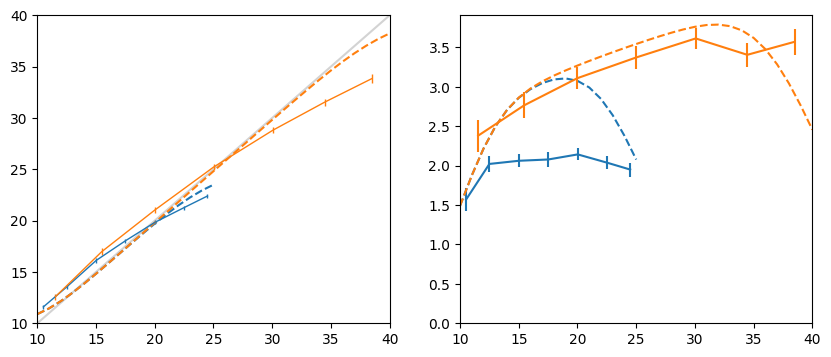

In [543]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    zpxs = get_interp_wideZipfprior(cond, alpha=0)
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(zpxs, θcost=.02)
    print(μxs)
    pxhatx, avg_ests, stddev_ests = model_predictions_cstvar(ZIPF_XS, zpxs, μxs, ν=ν, sd=.1, correct_xs=xs, NUM_RS=10_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond], ls='--')
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

## Rectified normal

In [711]:
def rectified_normal_Pab(a, b, mu, sigma, lo, hi):
    '''Probability that x is in [a,b], where x is a r.v. with *rectified* normal density.'''
    assert np.all(a<=b)
    aa = np.asarray(a, dtype=float)
    bb = np.asarray(b, dtype=float)
    mm = np.asarray(mu, dtype=float)
    assert aa.shape == bb.shape
    r = np.zeros( np.broadcast_shapes(aa.shape, mm.shape) )
    mask_bigger = (aa<=lo) & (bb>=hi) # extreme case, [a,b] contains [lo,hi]
    r[...,mask_bigger] = 1.
    mask_lo = (aa<=lo) & (bb<hi)      # [a,b] contains lo (but not hi)
    r[...,mask_lo] = num.std_normal_cdf( (bb[mask_lo]-mm)/sigma )
    mask_hi = (aa>lo) & (bb>=hi)      # [a,b] contains hi (but not lo)
    r[...,mask_hi] = num.std_normal_cdf( -(aa[mask_hi]-mm)/sigma )
    mask_in = (aa>lo) & (bb<hi)       # [a,b] inside [lo,hi]
    r[...,mask_in] = num.std_normal_cdf_difference( (aa[mask_in]-mm)/sigma, (bb[mask_in]-mm)/sigma )
    return r

In [712]:
print( stats.norm(loc=12, scale=2).cdf(12.5)-stats.norm(loc=12, scale=2).cdf(11.5) )
rectified_normal_Pab(a=11.5, b=12.5, mu=12, sigma=2, lo=10, hi=25)

0.1974126513658474


array(0.19741265)

In [713]:
print( stats.norm(loc=12, scale=2).cdf(10.5) )
rectified_normal_Pab(a=9.5, b=10.5, mu=12, sigma=2, lo=10, hi=25)

0.2266273523768682


array(0.22662735)

In [714]:
print( stats.norm(loc=22, scale=2).sf(24.5) )
rectified_normal_Pab(a=24.5, b=25.5, mu=22, sigma=2, lo=10, hi=25)

0.10564977366685535


array(0.10564977)

In [715]:
def probs_xhats_given_xB_rectified(xB, lo, w, σ):
    '''Given a Bayesian estimate xB, and some *rectified*-Gaussian noise with parameter σ,
    this returns the probability of each possible discrete (integer) response xhat between lo and lo+w.'''
    hi = lo + w
    if σ == 0:
        ps = np.zeros(int(w)+1)
        ps[int(np.round(xB)-lo)] = 1.
        return ps
    xhats = num.discrete_xs(lo, w)
    ps = rectified_normal_Pab(a=xhats-.5, b=xhats+.5, mu=xB, sigma=σ, lo=lo-.5, hi=hi+.5)
    #assert np.allclose(ps.sum(axis=-1), 1)
    if not np.allclose(ps.sum(axis=-1), 1):
        warnings.warn('p xhats given xB does not sum to 1.')
    return ps

def probs_xhats_given_xBs_rectified_array(xBs, lo, w, σ):
    '''Same as probs_xhats_given_xB_rectified but for an array of xBs.'''
    assert xBs.ndim == 1
    if σ == 0:
        ps = np.zeros((len(xBs), int(w)+1))
        for ixB,xB in enumerate(xBs):
            ps[ixB, max(0,min(int(w),int(np.round(xB)-lo))) ] = 1.
        return ps
    return probs_xhats_given_xB_rectified(xBs[...,np.newaxis], lo, w, σ)

In [716]:
probs_xhats_given_xBs_rectified_array(np.array([10, 10.5, 11, 11.5]), lo=10, w=15, σ=2)

array([[5.98706326e-01, 1.74666322e-01, 1.20977579e-01, 6.55906168e-02, 2.78346842e-02, 9.24470942e-03, 2.40273819e-03, 4.88607757e-04,
        7.77287594e-05, 9.67144253e-06, 9.41033637e-07, 7.15874327e-08, 4.25694611e-09, 1.97834085e-10, 7.18387196e-12, 2.08385816e-13],
       [5.00000000e-01, 1.91462461e-01, 1.49882285e-01, 9.18480527e-02, 4.40570693e-02, 1.65404666e-02, 4.85976729e-03, 1.11726895e-03,
        2.00957837e-04, 2.82735687e-05, 3.11102155e-06, 2.67662009e-07, 1.80029748e-08, 9.46427639e-10, 3.88801933e-11, 1.27981254e-12],
       [4.01293674e-01, 1.97412651e-01, 1.74666322e-01, 1.20977579e-01, 6.55906168e-02, 2.78346842e-02, 9.24470942e-03, 2.40273819e-03,
        4.88607757e-04, 7.77287594e-05, 9.67144253e-06, 9.41033637e-07, 7.15874327e-08, 4.25694611e-09, 1.97834085e-10, 7.39225778e-12],
       [3.08537539e-01, 1.91462461e-01, 1.91462461e-01, 1.49882285e-01, 9.18480527e-02, 4.40570693e-02, 1.65404666e-02, 4.85976729e-03,
        1.11726895e-03, 2.00957837e-04, 2.827

In [717]:
def probs_xhats_given_x_with_μxs_rectified(sxs, spxs, μxs, ν, σ, lo=None, w=None, NUM_RS=10_000, NUM_STDS=4):
    assert sxs.shape == spxs.shape
    assert sxs.shape == μxs.shape
    lo = sxs[0] if lo is None else lo
    w  = (sxs[-1]-sxs[0]) if w is None else w
    if ν==0:
        p_xhats_given_xs = probs_xhats_given_xBs_rectified_array(sxs, lo=lo, w=w, σ=σ)
    else:
        rs = np.linspace(-NUM_STDS*ν, 1+NUM_STDS*ν, num=NUM_RS)
        p_rs_μxs = num.probs_rs_given_μxs(rs, μxs, ν) # shape = (size of sxs, NUM_RS)
        # If the noise is small some rs will have probability zero. To avoid problems further down, we filter them out.
        ind_impossible_rs = p_rs_μxs.max(axis=0) == 0
        p_possible_rs_μxs = p_rs_μxs[:, ~ind_impossible_rs]
        xBs = num.xBs_using_p_rs_μxs(sxs, spxs, p_possible_rs_μxs)
        #p_rs_μxs is p(r|x)   ### ===> it is p(xB(r) | x)
        p_xhats_given_xBs = probs_xhats_given_xBs_rectified_array(xBs, lo=lo, w=w, σ=σ) # shape = (NUM_RS_filtered, size of xhats)
        p_xhats_given_xs = np.dot(p_possible_rs_μxs, p_xhats_given_xBs) # p(xhat | x)
    #assert np.allclose( p_xhats_given_xs.sum(axis=1), 1 )
    if not np.allclose( p_xhats_given_xs.sum(axis=1), 1 ):
        warnings.warn('p_xhats_given_xs does not sum to 1.')
    return p_xhats_given_xs # p(xhat | x), shape = (size of sxs, size of xs). And p_xhats_given_xs[i] = probs of xhats given x=x_i

In [718]:
def model_predictions_rectified(sxs, spxs, μxs, ν, σ, correct_xs=None, NUM_RS=100_000):
    if correct_xs is None: correct_xs = sxs
    pxhatx = probs_xhats_given_x_with_μxs_rectified(sxs, spxs, μxs, ν=ν, σ=σ, lo=correct_xs[0], w=correct_xs[-1]-correct_xs[0], NUM_RS=NUM_RS)
    pxhatx = pxhatx[ np.isin(sxs, correct_xs) ]
    #print(pxhatx.shape)
    avg_ests = (pxhatx*correct_xs).sum(axis=1)
    #print(avg_ests.shape)
    stddev_ests = np.sqrt( (pxhatx*(xs-avg_ests[...,np.newaxis])**2).sum(axis=1) )
    return pxhatx, avg_ests, stddev_ests

In [719]:
def mLL_rectified(dat, sxs, spxs, μxs, ν, σ, w, lo=10, NUM_RS=10_000):
    #print( ν, σ, w )
    pxhatx = probs_xhats_given_x_with_μxs_rectified(sxs, spxs, μxs, ν=ν, σ=σ, lo=lo, w=w, NUM_RS=NUM_RS)
    #print(pxhatx)
    pxhatx_onsupport = pxhatx[(sxs>=lo) & (sxs<=(lo+w))]
    logpxhatx = np.where(pxhatx_onsupport>0, pxhatx_onsupport, -np.inf)
    np.log(logpxhatx, out=logpxhatx, where=logpxhatx>0)
    #print(logpxhatx)
    return -logpxhatx[dat.n.astype(int)-lo,dat.response.astype(int)-lo].sum()

In [720]:
def mLL_with_ν_rectified(dat, cond, ν, σ, NUM_RS=10_000): # straightfoward with ν
    xs = XS_COND[cond]
    pxs = PRIORS_COND[cond]
    correct_w = WIDTHS_COND[cond]
    dat_ = dat[dat.range==cond]
    μxs = np.linspace(0, 1, len(xs))
    return mLL_rectified(dat_, xs, pxs, μxs, ν, σ, w=correct_w, lo=10, NUM_RS=NUM_RS)


In [673]:
@cache
def mLL_allsubjects_with_ν_rectified(cond, ν, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)]
    return mLL_with_ν_rectified(dat, cond, ν, σ, NUM_RS=NUM_RS) 
@cache
def mLL_onesubject_with_ν_rectified(sid, cond, ν, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)].loc[sid]
    return mLL_with_ν_rectified(dat, cond, ν, σ, NUM_RS=NUM_RS) 

In [721]:
def objf_basemodel_rectified(x):
    ν_n, σ = x
    ν_w = np.sqrt(2)*ν_n
    r  = mLL_allsubjects_with_ν_rectified('narrow', ν=ν_n, σ=σ)
    r += mLL_allsubjects_with_ν_rectified('wide', ν=ν_w, σ=σ)
    #print(x, r)
    return r
res, all_res = min_objf(objf_basemodel_rectified, x0s=itertools.product([.001, .01, .1, .2], [2,3]), bounds=[(1e-5,2.), (1e-2,None), ], return_all_res=True )
print(res)

(0.001, 2) -> [1.00012394e-03 3.70104792e+00] 30022.5799670365
(0.001, 3) -> [1.00000000e-03 3.70104753e+00] 30022.579967036465
(0.01, 2) -> [0.10341558 2.28308071] 29004.380833678635
(0.01, 3) -> [0.08106937 3.40226702] 29473.465603232835
(0.1, 2) -> [0.10341459 2.28310142] 29004.380833384632
(0.1, 3) -> [0.10341474 2.28310317] 29004.380833394636
(0.2, 2) -> [0.10341456 2.28310201] 29004.380833384603
(0.2, 3) -> [0.10341456 2.28310213] 29004.38083338465
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 29004.380833384603
        x: [ 1.034e-01  2.283e+00]
      nit: 8
      jac: [ 3.638e-03  0.000e+00]
     nfev: 42
     njev: 14
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


/Users/apc/Documents/Neuro/numerosity-fmri/neural_priors/.venv/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(0.0, 4.929047525489849)

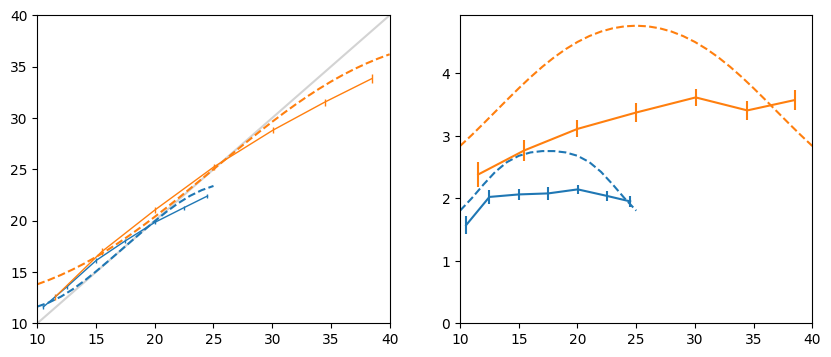

In [722]:
fig, axs = plt.subplots(ncols=2, figsize=(10,4))
for ic,cond in enumerate( CONDITIONS ):
    xs = XS_COND[cond]
    pxs = PRIORS_COND[cond]
    μxs = np.linspace(0,1,len(xs))
    σ = res.x[1]
    ν = res.x[0]*(np.sqrt(2) if cond=='wide' else 1)
    pxhatx, avg_ests, stddev_ests = model_predictions_rectified(xs, pxs, μxs, ν=ν, σ=σ, NUM_RS=10_000)
    axs[0].plot(xs, avg_ests, c=COLORS_COND[cond], ls='--')
    axs[1].plot(xs, stddev_ests, c=COLORS_COND[cond], ls='--')
    #### Subjects
    for k, avgzz in binAvgs[cond].items():
        ns = binNs[cond][k] # shape = (nbSubj, k)
        stdzz = binStds[cond][k]
        xx = ns.mean(axis=0)
        if k=='A':
            pass #axs[0].plot(xx, np.nanmean(avgzz, axis=0), '.-', c=COLORS_COND[cond], alpha=.2, ms=2)
        else:
            axs[0].errorbar(xx, np.nanmean(avgzz, axis=0), stats.sem( avgzz, axis=0 ), c=COLORS_COND[cond], label=cond, lw=1)
            axs[1].errorbar(xx, np.nanmean(stdzz, axis=0), stats.sem( stdzz, axis=0 ), c=COLORS_COND[cond], label=cond)
axs[0].axline((10,10), slope=1, color='lightgrey', zorder=-1000)
axs[0].set_xlim(10,40); axs[0].set_ylim(10,40); 
axs[1].set_xlim(10,40); axs[1].set_ylim(0,None)

In [680]:
pxhatx[0].sum()

0.9999999999999999

array([2.83687203, 3.01321048, 3.19761421, 3.38645343, 3.57566981, 3.76103687, 3.93843305, 4.10409487, 4.25482   , 4.38809689, 4.50214767,
       4.59588329, 4.66878356, 4.7207268 , 4.75180219, 4.76214141, 4.75180219, 4.7207268 , 4.66878356, 4.59588329, 4.50214767, 4.38809689,
       4.25482   , 4.10409487, 3.93843305, 3.76103687, 3.57566981, 3.38645343, 3.19761421, 3.01321048, 2.83687203])

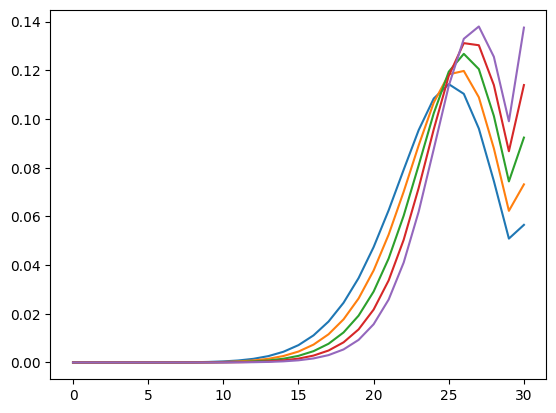

In [726]:
plt.plot( pxhatx[-5:].T );
stddev_ests

## Free prior

In [813]:
def make_Pxs(xs, some_Ps):
    '''some_Ps does not contain the "first" and "last" values of P, which we will always assume to be 0 and 1.'''
    Pvals = np.r_[0., some_Ps, 1.]
    assert np.all(Pvals>=0)
    assert np.all(Pvals<=1)
    print(Pvals, np.diff(Pvals))
    assert np.all(np.diff(Pvals)>=0)
    xps = np.linspace(xs[0]-1, xs[-1], num=len(Pvals))
    return np.interp(xs, xps, Pvals)

def make_pxs_from_Pxs(Pxs):
    return np.diff(Pxs, prepend=0)

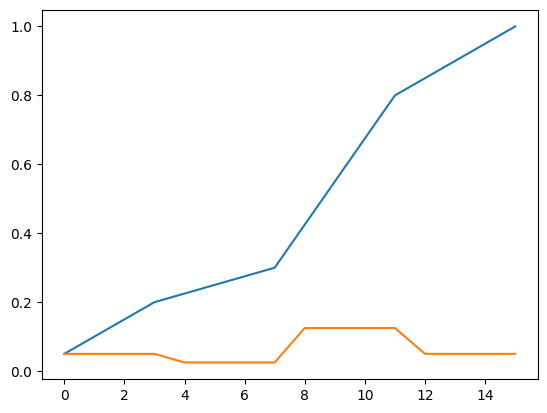

In [807]:
some_Ps = [.2,.3,.8]
plt.plot( make_Pxs(XS_COND['narrow'], some_Ps=some_Ps) )
plt.plot( make_pxs_from_Pxs( make_Pxs(XS_COND['narrow'], some_Ps=some_Ps) ) )

In [803]:
def mLL_effcoding_free_prior(dat, cond, some_Ps, θcost, σ, NUM_RS=10_000):
    xs = XS_COND[cond]
    spxs = make_pxs_from_Pxs( make_Pxs(xs, some_Ps=some_Ps) )
    Ixs, μxs, ν = opt_Ixs_μxs_and_ν(spxs=spxs, θcost=θcost)
    correct_w = WIDTHS_COND[cond]
    return mLL(dat, xs, spxs, μxs, ν, σ, correct_w, NUM_RS=NUM_RS)

In [808]:
@cache
def mLL_allsubjects_free_prior_3P(cond, some_Ps, θcost, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)]
    return mLL_effcoding_free_prior(dat, cond, some_Ps, θcost, σ, NUM_RS=NUM_RS)

In [816]:
# TODO

In [815]:
def objf_freeprior_3P(x):
    some_Ps_n = x[:3]
    some_Ps_w = x[3:6]
    θcost, σ = x[6:]    
    r  = mLL_allsubjects_free_prior_3P('narrow', tuple(some_Ps_n), θcost, σ)
    r += mLL_allsubjects_free_prior_3P('wide', tuple(some_Ps_w), θcost, σ)
    #print(x, r)
    return r
res = min_objf(objf_freeprior_3P, x0s=[[.25 ,.5, .75, .25 ,.5, .75, .2, 2]],
               bounds=[(0,1),]*6 + [(0,None), (0,None) ],
               constraints=[dict(type='ineq', fun=lambda x: np.diff(x[:3]).min()), dict(type='ineq', fun=lambda x: np.diff(x[3:6]).min()), ])
print(res)

[0.   0.25 0.5  0.75 1.  ] [0.25 0.25 0.25 0.25]
[0.   0.25 0.5  0.75 1.  ] [0.25 0.25 0.25 0.25]
[0.         0.25000001 0.5        0.75       1.        ] [0.25000001 0.24999999 0.25       0.25      ]
[0.         0.25       0.50000001 0.75       1.        ] [0.25       0.25000001 0.24999999 0.25      ]
[0.         0.25       0.5        0.75000001 1.        ] [0.25       0.25       0.25000001 0.24999999]
[0.         0.25000001 0.5        0.75       1.        ] [0.25000001 0.24999999 0.25       0.25      ]
[0.         0.25       0.50000001 0.75       1.        ] [0.25       0.25000001 0.24999999 0.25      ]
[0.         0.25       0.5        0.75000001 1.        ] [0.25       0.25       0.25000001 0.24999999]
[0.   0.25 0.5  0.75 1.  ] [0.25 0.25 0.25 0.25]
[0.   0.25 0.5  0.75 1.  ] [0.25 0.25 0.25 0.25]
[0.   0.25 0.5  0.75 1.  ] [0.25 0.25 0.25 0.25]
[0.   0.25 0.5  0.75 1.  ] [0.25 0.25 0.25 0.25]
[0. 1. 0. 1. 1.] [ 1. -1.  1.  0.]


AssertionError: 

In [849]:
@cache
def mLL_allsubjects_totalfreeprior_cstnoise(cond, pxs, ν, σ, NUM_RS=10_000):
    dat = beh[ (beh.range==cond) & ~pd.isna(beh.response)]
    xs = XS_COND[cond]
    spxs = np.array(pxs)
    assert len(xs) == len(spxs)
    #Ixs, μxs, ν = opt_Ixs_μxs_and_ν(spxs=spxs, θcost=θcost)
    μxs = np.linspace(0,1,len(xs))
    correct_w = WIDTHS_COND[cond]
    return mLL(dat, xs, spxs, μxs, ν, σ, correct_w, NUM_RS=NUM_RS)

In [850]:
def objf_totalfree_n_test(x):
    pxs = tuple(x)
    r = mLL_allsubjects_totalfreeprior_cstnoise(cond='narrow', pxs=pxs, ν=.17, σ=3, NUM_RS=10_000)
    print(x, r)
    return r

In [851]:
res = min_objf(objf_totalfree_n_test, x0s=[PRIORS_COND['narrow'],], bounds=[(0.001,.999),]*len(PRIORS_COND['narrow']),
               constraints=[dict(type='eq', fun=lambda x: x.sum()-1)])
res

[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625] 13399.084154977318
[0.06250001 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ] 13399.08414606574
[0.0625     0.06250001 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ] 13399.084154221036
[0.0625     0.0625     0.06250001 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ] 13399.084159394588
[0.0625     0.0625     0.0625     0.06250001 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ] 13399.084161715204
[0.0625     0.0625     0.0625     0.0625     0.06250001 0.0625     0.0625     0.0625     0.0

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 13275.386327005575
       x: [ 2.235e-01  1.000e-03 ...  1.000e-03  2.020e-01]
     nit: 15
     jac: [-6.021e-01  1.394e+02 ...  1.213e+01 -5.946e-01]
    nfev: 262
    njev: 15

In [852]:
res.x.sum()

1.0000000011979413

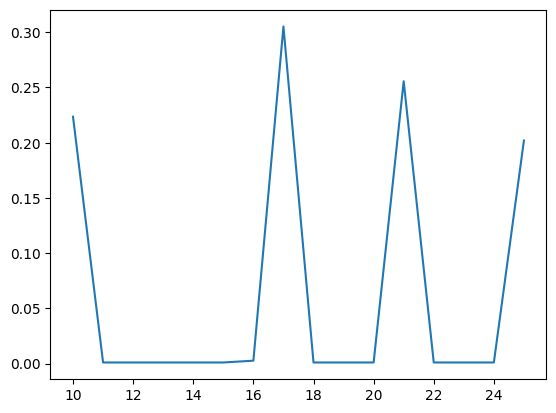

In [853]:
plt.plot(XS_COND['narrow'], res.x)

# Recap LLs

In [809]:
[1,2,3,4][3:]

[4]

| Model | k | -LL | Notes |
|---|---|---|---|
|No cog noise|2| 29007.61 |
|Constrained $\nu$ |2| 29149.29|
|Subjective prior (correct support) Zipf 2  |3| 29048.87 | $\alpha=0$
|Subjective prior (correct support) Zipf 1.1|3| 29128.87 | $\alpha=0$
|Subjective prior (correct support) Zipf 2 n/w  |4|28968.40| $\alpha_w=0$
|Subjective prior (correct support) Zipf 1.1 n/w|4| 29102.28 | $\alpha_w=0$
|Subjective prior (wider support) Zipf 2  |3|28985.31|
|Subjective prior (wider support) Zipf 1.1|3|28925.16|
|Subjective prior (wider support) n/w Zipf 2  |4|28850.34|
|Subjective prior (wider support) n/w Zipf 1.1|4|28841.77|
|||||
|Constrained $\nu$, rectified Gaussian|2|29004.38|